# Ocean PAMA-seq and metagenomic subsampling analysis

### Objective
1. PAMA-seq requires less sequencing than metagenomics for cross-domain taxonomic analysis
2. calculate the shannon index at differnet taxon levels with read depth of 1000 to 10000000
3. calculate the relative standard error for each taxon with read depth of 1000 to 10000000

In [6]:
from Bio import Entrez
from Bio import Phylo
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from Bio import Entrez
from matplotlib.colors import LogNorm, Normalize
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.cm as cm
from skbio.diversity import alpha_diversity
from skbio.diversity import beta_diversity
from skbio.stats.distance import anosim
from scipy.cluster.hierarchy import linkage, dendrogram
from skbio.stats.ordination import pcoa
from scipy.stats import f_oneway, spearmanr
from skbio.stats.distance import mantel
from skbio.stats.distance import DistanceMatrix
from scipy.spatial.distance import pdist, squareform
from matplotlib import gridspec


In [177]:
# wk_dir = '/home/xiangpeng/projects/16S_18S/ocean/ocean_PAM-seq/'
wk_dir = '/home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/'
out_dir = '/home/xiangpeng/projects/16S_18S/code_for_github/output/ocean_subsample/'
pam_file = wk_dir + 'PAMA-seq_subsample_taxa.csv'
pam = pd.read_csv(pam_file, index_col =0)

In [178]:
pam.head()

gut_combined_1000_1  gut_combined_1000_2  gut_combined_1000_3  \
10394                    0                    0                    0   
6123                     0                    0                    0   
14272                    0                    0                    0   
17825                    0                    0                    0   
12115                    0                    0                    0   

       gut_combined_1000_4  gut_combined_1000_5  gut_combined_10000_1  \
10394                    0                    0                     0   
6123                     0                    0                     0   
14272                    0                    0                     0   
17825                    0                    0                     0   
12115                    0                    0                     0   

       gut_combined_10000_2  gut_combined_10000_3  gut_combined_10000_4  \
10394                     0                     0                     0   
6123                      0                     0                     0   
14272                     0                     0                     0   
17825                     0                     0                     0   
12115                     0                     0                     0   

       gut_combined_10000_5  ...                               ASV   Kingdom  \
10394                     0  ...  1fc702b2cf995509b3a91e8cea2f3224  Bacteria   
6123                      0  ...  87e136ad633cf09f5f51276411939ae4  Bacteria   
14272                     0  ...  bd01a266418f8e275d83afb23d38bd69  Bacteria   
17825                     0  ...  8471dd95f3ca8f172602ca90ffb153d0  Bacteria   
12115                     0  ...  80894c43ace63e5099e56bb49cfb4e35  Bacteria   

               Phylum                Class            Order            Family  \
10394       Bacillota              Bacilli       Bacillales       Bacillaceae   
6123   Pseudomonadota  Gammaproteobacteria  Pseudomonadales  Pseudomonadaceae   
14272  Pseudomonadota  Gammaproteobacteria  Pseudomonadales  Pseudomonadaceae   
17825       Bacillota              Bacilli       Bacillales       Bacillaceae   
12115       Bacillota           Clostridia   Lachnospirales   Lachnospiraceae   

                   Genus                              Species  \
10394  Hydrogenibacillus             [Bacillus] solfatarensis   
6123         Pseudomonas  [Brevibacterium] frigoritolerans      
14272        Pseudomonas  [Brevibacterium] frigoritolerans      
17825           Bacillus     [Brevibacterium] halotolerans      
12115  Lachnoclostridium  [Clostridium] algidixylanolyticum     

                                              Full_Taxon  \
10394  Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...   
6123   Bacteria;Proteobacteria;Gammaproteobacteria;Ps...   
14272  Bacteria;Proteobacteria;Gammaproteobacteria;Ps...   
17825  Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...   
12115  Bacteria;Firmicutes;Clostridia;Clostridiales;L...   

                                                Sequence  
10394  TCGCAACAGCAGTGGCTGCGACAGCCGTGTCTAGGGCAACTGGAGG...  
6123   AGGTAGACTGGGAGTATTTCTCTGAAATCTTCGTTGGCATTATCGA...  
14272  GCGAGGCAGACTGCACATTAATCGGCGTCACCGTTGGTAGCGCCGT...  
17825  CTCAACGAACACGACAGCTCGCGCTTCGACTGGGAGAAGCGCGGAC...  
12115  ATCCGAATTTACCTTCCTCCAATGTCTTGACATTCAAAATGGTGCC...  

[5 rows x 60 columns]

In [179]:
ocean_ls = ['ocean_combined_1000_1','ocean_combined_1000_2','ocean_combined_1000_3',
            'ocean_combined_1000_4','ocean_combined_1000_5', 'ocean_combined_10000_1',
       'ocean_combined_10000_2', 'ocean_combined_10000_3',
       'ocean_combined_10000_4', 'ocean_combined_10000_5',
       'ocean_combined_100000_1', 'ocean_combined_100000_2',
       'ocean_combined_100000_3', 'ocean_combined_100000_4',
       'ocean_combined_100000_5', 'ocean_combined_1000000_1',
       'ocean_combined_1000000_2', 'ocean_combined_1000000_3',
       'ocean_combined_1000000_4', 'ocean_combined_1000000_5',
       'ocean_combined_10000000_1', 'ocean_combined_10000000_2',
       'ocean_combined_10000000_3', 'ocean_combined_10000000_4',
       'ocean_combined_10000000_5',]

taxa_levels = ['Kingdom', 'Phylum', 'Class','Order', 'Family', 'Genus', 'Species', 'Full_Taxon',]

In [180]:
pam_filtered = pam[~(pam[ocean_ls]==0).all(axis=1)]
pam_filtered.head()

gut_combined_1000_1  gut_combined_1000_2  gut_combined_1000_3  \
10394                    0                    0                    0   
6123                     0                    0                    0   
14272                    0                    0                    0   
17825                    0                    0                    0   
12115                    0                    0                    0   

       gut_combined_1000_4  gut_combined_1000_5  gut_combined_10000_1  \
10394                    0                    0                     0   
6123                     0                    0                     0   
14272                    0                    0                     0   
17825                    0                    0                     0   
12115                    0                    0                     0   

       gut_combined_10000_2  gut_combined_10000_3  gut_combined_10000_4  \
10394                     0                     0                     0   
6123                      0                     0                     0   
14272                     0                     0                     0   
17825                     0                     0                     0   
12115                     0                     0                     0   

       gut_combined_10000_5  ...                               ASV   Kingdom  \
10394                     0  ...  1fc702b2cf995509b3a91e8cea2f3224  Bacteria   
6123                      0  ...  87e136ad633cf09f5f51276411939ae4  Bacteria   
14272                     0  ...  bd01a266418f8e275d83afb23d38bd69  Bacteria   
17825                     0  ...  8471dd95f3ca8f172602ca90ffb153d0  Bacteria   
12115                     0  ...  80894c43ace63e5099e56bb49cfb4e35  Bacteria   

               Phylum                Class            Order            Family  \
10394       Bacillota              Bacilli       Bacillales       Bacillaceae   
6123   Pseudomonadota  Gammaproteobacteria  Pseudomonadales  Pseudomonadaceae   
14272  Pseudomonadota  Gammaproteobacteria  Pseudomonadales  Pseudomonadaceae   
17825       Bacillota              Bacilli       Bacillales       Bacillaceae   
12115       Bacillota           Clostridia   Lachnospirales   Lachnospiraceae   

                   Genus                              Species  \
10394  Hydrogenibacillus             [Bacillus] solfatarensis   
6123         Pseudomonas  [Brevibacterium] frigoritolerans      
14272        Pseudomonas  [Brevibacterium] frigoritolerans      
17825           Bacillus     [Brevibacterium] halotolerans      
12115  Lachnoclostridium  [Clostridium] algidixylanolyticum     

                                              Full_Taxon  \
10394  Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...   
6123   Bacteria;Proteobacteria;Gammaproteobacteria;Ps...   
14272  Bacteria;Proteobacteria;Gammaproteobacteria;Ps...   
17825  Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...   
12115  Bacteria;Firmicutes;Clostridia;Clostridiales;L...   

                                                Sequence  
10394  TCGCAACAGCAGTGGCTGCGACAGCCGTGTCTAGGGCAACTGGAGG...  
6123   AGGTAGACTGGGAGTATTTCTCTGAAATCTTCGTTGGCATTATCGA...  
14272  GCGAGGCAGACTGCACATTAATCGGCGTCACCGTTGGTAGCGCCGT...  
17825  CTCAACGAACACGACAGCTCGCGCTTCGACTGGGAGAAGCGCGGAC...  
12115  ATCCGAATTTACCTTCCTCCAATGTCTTGACATTCAAAATGGTGCC...  

[5 rows x 60 columns]

In [181]:

read_cnts = [1000, 1000,1000, 1000,1000, 
             10000, 10000,10000,10000,10000,
             100000, 100000, 100000, 100000, 100000, 
             1000000, 1000000,1000000,1000000,1000000,
             10000000,10000000,10000000,10000000,10000000,
            ]


# Group the read by taxon

In [182]:
# calcualte shannon index
def shannon_entropy(column):
    values = column.dropna()
    total = values.sum()
    if total == 0:
        return np.nan
    proportions = values / total
    return -np.sum(proportions * np.log(proportions))

In [183]:
taxa_up = ['Kingdom', 'Phylum', 'Class','Order', 'Family', 'Genus', 'Species',]
cnt_depths = [1000, 10000, 100000, 1000000, 10000000]
pama_shannon = pd.DataFrame()
for t in taxa_up:
    cmb_df = pam_filtered.groupby(by= [t])[ocean_ls].sum().replace(0, np.nan) 
    cmb_df =  cmb_df.div(read_cnts) # relative abundance
    cmb_df.to_csv(out_dir + 'ocean_pam_subsample_read_cnt_by_{}.csv'.format(t))
    
    shannon_indices = cmb_df.apply(shannon_entropy, axis=0)
    pama_shannon[t] = shannon_indices
pama_shannon = pama_shannon.T
pama_shannon.to_csv(out_dir + 'ocean_pam_subsample_shannon_index_all_taxon.csv')
       


In [184]:
pama_shannon_mean =  pd.DataFrame()
pama_shannon_std = pd.DataFrame()
for cnt in cnt_depths:
    cols = pama_shannon.columns[pama_shannon.columns.str.contains('_{}_'.format(cnt))]
    pama_shannon_mean[cnt] = pama_shannon[cols].mean(axis=1)
    pama_shannon_std[cnt] = pama_shannon[cols].std(axis=1)


pama_shannon_mean.to_csv('ocean_pam_subsample_shannon_index_all_taxon_mean.csv')
pama_shannon_std.to_csv('ocean_pam_subsample_shannon_index_all_taxon_std.csv')

In [185]:
pama_shannon_mean

1000      10000     100000    1000000   10000000
Kingdom  0.618414  0.678156  0.690029  0.692344  0.696720
Phylum   2.349786  2.670700  2.779773  2.815555  2.832890
Class    2.352177  2.852796  2.997438  3.054085  3.080259
Order    2.781460  3.391615  3.596853  3.682419  3.716284
Family   2.960636  3.638838  3.886509  3.992023  4.032065
Genus    2.914570  3.628501  3.880437  3.988568  4.037514
Species  2.793306  3.467029  3.695814  3.796572  3.860371

<Axes: >

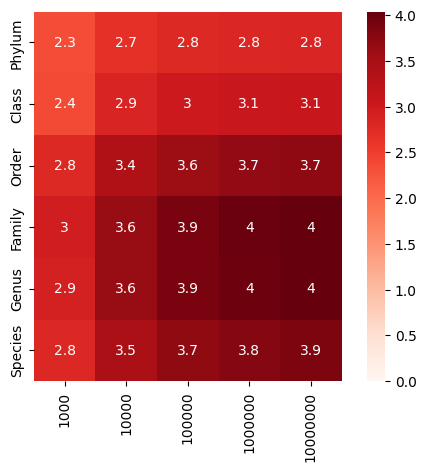

In [186]:
sns.heatmap(pama_shannon_mean.iloc[1:],
            cmap='Reds',
            vmin=0,
            #vmax = 10,
            annot =True,
            square = True,
           )

In [187]:
for t in taxa_up:
    cmb_df =  pd.read_csv(out_dir + 'ocean_pam_subsample_read_cnt_by_{}.csv'.format(t), index_col = 0 ) # load data by the taxon

    # initialize the dataframes
    cmb_rel_by_read_cnt = pd.DataFrame(index = cmb_df.index)
    cmb_rel_by_read_cnt_err = pd.DataFrame(index = cmb_df.index)
    min_rel_abd = pd.DataFrame(index = [t])
    total_rel_abd = pd.DataFrame(index = [t])

    for cnt in cnt_depths:
        sub_cnt_df = cmb_df.loc[:, cmb_df.columns.str.startswith('ocean_combined_'+str(cnt)+'_')]

        cmb_rel_by_read_cnt[cnt]= sub_cnt_df.T.mean()
   
        cmb_rel_by_read_cnt_err[cnt] = sub_cnt_df.T.std()
        min_rel_abd[cnt] = sub_cnt_df.T.min().min()
        total_rel_abd[cnt] = sub_cnt_df.sum().mean()

    # sort the values
    cmb_rel_by_read_cnt['sum'] = cmb_rel_by_read_cnt.sum(axis=1)
    cmb_rel_by_read_cnt = cmb_rel_by_read_cnt.sort_values(by='sum', ascending=False)
    cmb_rel_by_read_cnt = cmb_rel_by_read_cnt.drop(columns='sum')
    
    # remove empty rows
    cmb_rel_by_read_cnt = cmb_rel_by_read_cnt.dropna(how='all')
    cmb_rel_by_read_cnt_err = cmb_rel_by_read_cnt_err.loc[cmb_rel_by_read_cnt.index]

    # save the data
    cmb_rel_by_read_cnt.to_csv(out_dir + '{}_pam-seq_combined_relative_abundance_by_read_count.csv'.format(t))
    cmb_rel_by_read_cnt_err.to_csv(out_dir + '{}_pam-seq_combined_relative_abundance_error_by_read_count.csv'.format(t))
    min_rel_abd.to_csv(out_dir + '{}_pam-seq_minimal_relative_abundance_by_read_count.csv'.format(t))
    total_rel_abd.to_csv(out_dir + '{}_pam-seq_total_annotated_relative_abundance_by_read_count.csv'.format(t))

    


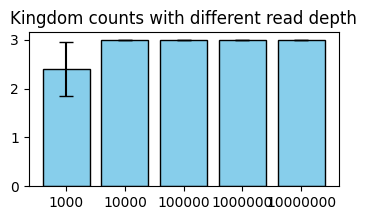

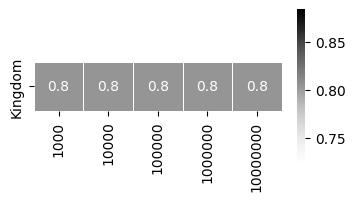

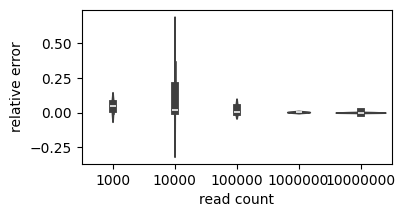

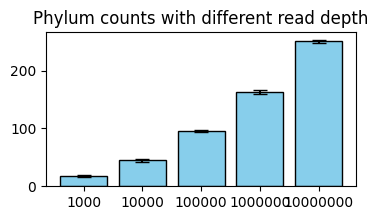

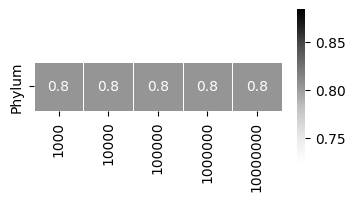

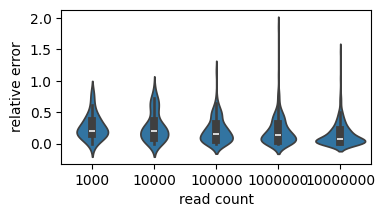

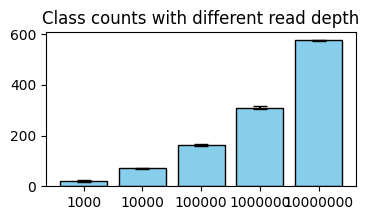

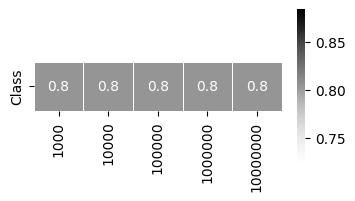

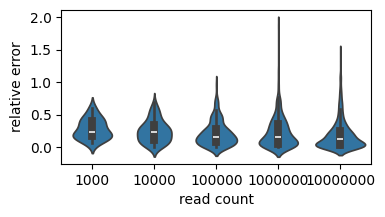

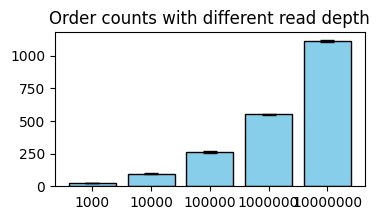

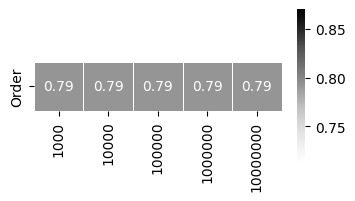

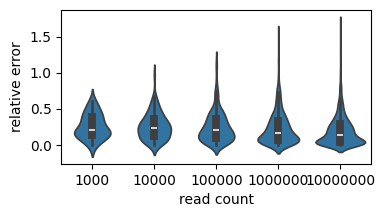

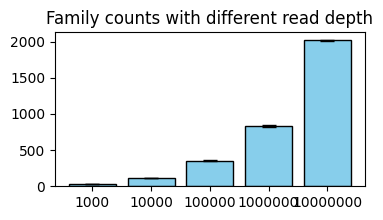

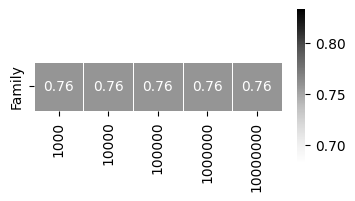

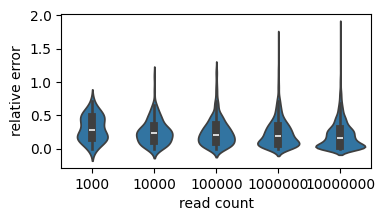

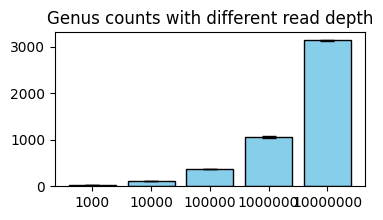

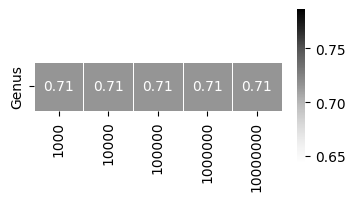

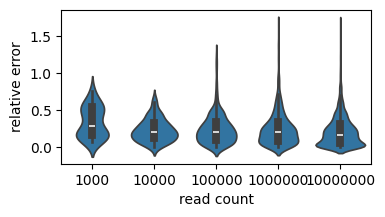

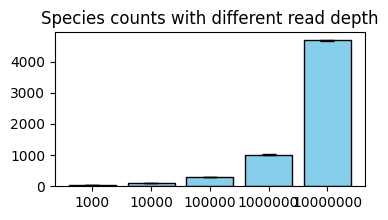

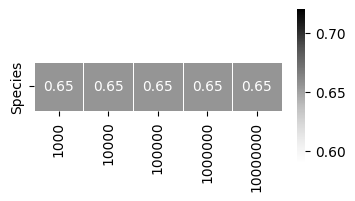

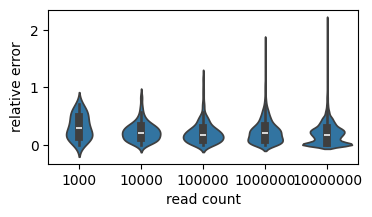

Species read count  relative error
0      Phaseoleae environmental sample       1000        0.138928
1                 Hastigerina pelagica       1000        0.134652
2             Remanella sp. 2 WS-2012        1000        0.157633
3      Poduridae environmental sample        1000        0.181057
4                 uncultured bacterium       1000        0.690448
...                                ...        ...             ...
36935   Verrucomicrobium sp. KLE1210     10000000             NaN
36936                 Euglena sp. MI32   10000000             NaN
36937            Euglenaformis proxima   10000000             NaN
36938              Euglenaria anabaena   10000000        0.000000
36939             Euplotes sp. EdPoA02   10000000        0.000000

[36940 rows x 3 columns]

In [262]:
# plot the taxon counts, total abundance, and the relative errors. 
for t in taxa_up:
    cmb_df =  pd.read_csv(out_dir + 'ocean_pam_subsample_read_cnt_by_{}.csv'.format(t), index_col = 0 ) # load data by the taxon
    cmb_rel_by_read_cnt = pd.read_csv(out_dir + '{}_pam-seq_combined_relative_abundance_by_read_count.csv'.format(t), index_col =0)
    cmb_rel_by_read_cnt_err = pd.read_csv(out_dir + '{}_pam-seq_combined_relative_abundance_error_by_read_count.csv'.format(t), index_col =0)
    min_rel_abd = pd.read_csv(out_dir + '{}_pam-seq_minimal_relative_abundance_by_read_count.csv'.format(t), index_col =0)
    total_rel_abd = pd.read_csv(out_dir + '{}_pam-seq_total_annotated_relative_abundance_by_read_count.csv'.format(t), index_col =0)

    cmb_taxon_cnt = pd.DataFrame(index = [t])
    cmb_taxon_cnt_err = pd.DataFrame(index = [t])
    
    total_rel_abd = pd.DataFrame(index = [t])

    for cnt in cnt_depths:
        cmb_taxon_cnt[cnt] = cmb_df.count().loc[cmb_df.columns.str.startswith('ocean_combined_'+str(cnt)+'_')].mean()
        cmb_taxon_cnt_err[cnt] = cmb_df.count().loc[cmb_df.columns.str.startswith('ocean_combined_'+str(cnt)+'_')].std()

        total_rel_abd.loc[t, cnt] = cmb_df.sum().mean()
        
    cmb_taxon_cnt.to_csv(out_dir + 'ocean_pam_{}_level_taxa_count.csv'.format(t))
    cmb_taxon_cnt_err.to_csv(out_dir + 'ocean_pam_{}_level_taxa_count_error.csv'.format(t))

    # Extract values (first row, since each has only one row)
    values = cmb_taxon_cnt.iloc[0]
    errors = cmb_taxon_cnt_err.iloc[0]

    # Plotting
    plt.figure(figsize=(4,2))
    bars = plt.bar(values.index.astype('str'), values.values, yerr=errors.values, capsize=5, color='skyblue', edgecolor='black')

    # Customizing the plot
    plt.title('{} counts with different read depth'.format(t))

    # Show the plot

    plt.savefig(out_dir+'{}_czid_ocean_subsample_taxon_count.pdf'.format(t), )
    plt.show()

    
    ## plot the heatmap of the total read that mapped to database
    
    plt.figure(figsize=(4,2))
    sns.heatmap(total_rel_abd,
            #vmin =0,
            #vmax = 1,
            square = True,
            linewidths=0.5,
            annot = True,
            cmap = 'Grays',
            
           )
    plt.savefig(out_dir+'{}_persentage_reads_annotated_heatmap.pdf'.format(t), )
    plt.show()

    rel_error = cmb_rel_by_read_cnt_err/cmb_rel_by_read_cnt
    rel_error = rel_error.reset_index().melt(id_vars=[t], var_name = 'read count', value_name = 'relative error')
    rel_error['read count'] = rel_error['read count'].astype(str)
    plt.figure(figsize=(4,2))
    sns.violinplot(data = rel_error,
               x = 'read count',
               y = 'relative error',
              )
    #plt.ylim(0, 1)
    plt.savefig(out_dir+'{}_relative_error_violin.pdf'.format(t), )
    plt.show()
    rel_error.to_csv(out_dir+ 'pam-seq_ocean_{}_relative_error_for_violin_plot.csv'.format(t))

In [266]:
cmb_rel_by_read_cnt_err

1000     10000    100000   1000000  \
Species                                                                   
Phaseoleae environmental sample  0.020700  0.003128  0.001161  0.000445   
Hastigerina pelagica             0.010368  0.003098  0.000610  0.000151   
Remanella sp. 2 WS-2012          0.007503  0.002680  0.000435  0.000187   
Poduridae environmental sample   0.006301  0.001108  0.000186  0.000183   
uncultured bacterium             0.014223  0.001856  0.000332  0.000451   
...                                   ...       ...       ...       ...   
Verrucomicrobium sp. KLE1210          NaN       NaN       NaN       NaN   
Euglena sp. MI32                      NaN       NaN       NaN       NaN   
Euglenaformis proxima                 NaN       NaN       NaN       NaN   
Euglenaria anabaena                   NaN       NaN       NaN       NaN   
Euplotes sp. EdPoA02                  NaN       NaN       NaN       NaN   

                                 10000000  
Species                                    
Phaseoleae environmental sample  0.000119  
Hastigerina pelagica             0.000070  
Remanella sp. 2 WS-2012          0.000060  
Poduridae environmental sample   0.000033  
uncultured bacterium             0.000044  
...                                   ...  
Verrucomicrobium sp. KLE1210          NaN  
Euglena sp. MI32                      NaN  
Euglenaformis proxima                 NaN  
Euglenaria anabaena              0.000000  
Euplotes sp. EdPoA02             0.000000  

[7388 rows x 5 columns]

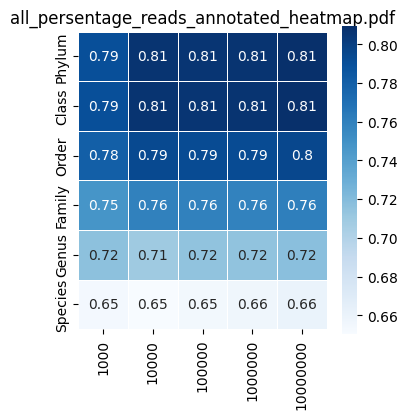

In [85]:
# plot the percentage read that are annotated (heatmap)
total_rel_abd_all_taxa = pd.DataFrame()

for t in taxa[1:]:
    total_rel_abd = pd.read_csv(out_dir + '{}_pam-seq_total_annotated_relative_abundance_by_read_count.csv'.format(t), index_col =0)
    total_rel_abd_all_taxa = pd.concat([total_rel_abd_all_taxa, total_rel_abd], axis=0)
    
plt.figure(figsize=(4,4))
sns.heatmap(total_rel_abd_all_taxa, 
            #vmin =0,
            #vmax = 1,
            square = True,
            linewidths=0.5,
            annot = True,
            cmap = 'Blues',
            
           )
plt.title('all_persentage_reads_annotated_heatmap.pdf')
plt.savefig(out_dir+'all_persentage_reads_annotated_heatmap.pdf', )
total_rel_abd_all_taxa.to_csv(out_dir+'all_persentage_reads_annotated_heatmap.csv')

In [263]:
rel_error

Species read count  relative error
0      Phaseoleae environmental sample       1000        0.138928
1                 Hastigerina pelagica       1000        0.134652
2             Remanella sp. 2 WS-2012        1000        0.157633
3      Poduridae environmental sample        1000        0.181057
4                 uncultured bacterium       1000        0.690448
...                                ...        ...             ...
36935   Verrucomicrobium sp. KLE1210     10000000             NaN
36936                 Euglena sp. MI32   10000000             NaN
36937            Euglenaformis proxima   10000000             NaN
36938              Euglenaria anabaena   10000000        0.000000
36939             Euplotes sp. EdPoA02   10000000        0.000000

[36940 rows x 3 columns]

## Metagenomic subsamples
### Kaiju 

In [189]:
taxa = ['phylum', 'class', 'order', 'family', 'genus', 'species'] 
read_cnts = ['1K', '10K', '100K', '1M', '10M']

In [224]:
for t in taxa:
    cmb_df = pd.DataFrame(columns =['taxon_id']) ## combined df 
   
    for cnt in read_cnts:
        for i in [1, 2, 3, 4, 5]:
            f = wk_dir + '{}_{}-{}-longtail.kaijuReport'.format(cnt, i, t)
            try:
                df = pd.read_csv(f, sep= '\t')
                df = df.set_index('taxon_name')
                df = df.rename(columns={'reads':'{}_{}-{}'.format(cnt, i, t)})
                cmb_df = pd.concat([cmb_df,df[['{}_{}-{}'.format(cnt, i, t)]]], axis=1)
                cmb_df.loc[df.index, 'taxon_id'] = df['taxon_id'].astype('str')
                
                
            except FileNotFoundError:
                print('file {} not found'.format(f))
    cmb_df = cmb_df.fillna(0)
    cmb_df.to_csv(wk_dir + 'ocean_{}_level_kaiju_read_counts.csv'.format(t))

file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-phylum-longtail.kaijuReport not found
file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-class-longtail.kaijuReport not found
file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-order-longtail.kaijuReport not found
file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-family-longtail.kaijuReport not found
file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-genus-longtail.kaijuReport not found
file /home/xiangpeng/projects/16S_18S/code_for_github/data/ocean_subsample/10M_2-species-longtail.kaijuReport not found


In [289]:
for t in taxa:

    cmb_df=pd.read_csv(wk_dir + 'ocean_{}_level_kaiju_read_counts.csv'.format(t), index_col=0)

    cmb_rel = cmb_df.drop(columns = ['taxon_id'])/cmb_df.drop(columns = ['taxon_id']).sum()
    cmb_rel = cmb_rel.replace(0, np.nan)
    cmb_rel = cmb_rel.drop(index = ['cannot be assigned to a (non-viral) {}'.format(t), 'unclassified'])
    

    cmb_rel_by_read_cnt = pd.DataFrame(index = cmb_rel.index)
    cmb_rel_by_read_cnt_err = pd.DataFrame(index = cmb_rel.index)
    min_rel_abd = pd.DataFrame(index = [t])
    total_rel_abd = pd.DataFrame(index = [t])
    read_cnts = ['1K', '10K', '100K', '1M', '10M']

    for cnt in read_cnts:
        cmb_rel_by_read_cnt[cnt]= cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.mean()
   
        cmb_rel_by_read_cnt_err[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.std()
        min_rel_abd[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.min().min()
        total_rel_abd[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].sum().mean()


    cmb_rel_by_read_cnt = cmb_rel_by_read_cnt.replace(0, np.nan)
    cmb_rel_by_read_cnt_err =cmb_rel_by_read_cnt_err.replace(0, np.nan)

    cmb_rel_by_read_cnt.to_csv(out_dir + '{}_kaiju_combined_relative_abundance_by_read_count.csv'.format(t))
    cmb_rel_by_read_cnt_err.to_csv(out_dir + '{}_kaiju_combined_relative_abundance_error_by_read_count.csv'.format(t))
    min_rel_abd.to_csv(out_dir + '{}_kaiju_minimal_relative_abundance_by_read_count.csv'.format(t))
    total_rel_abd.to_csv(out_dir + '{}_kaiju_total_annotated_relative_abundance_by_read_count.csv'.format(t))


    rel_error = cmb_rel_by_read_cnt_err/cmb_rel_by_read_cnt
    
    rel_error = rel_error.reset_index().melt(id_vars='index', var_name = 'read count', value_name = 'relative error')
    rel_error = rel_error.rename(columns = {"index": t.lower()})
    rel_error['read count'] = rel_error['read count'].astype(str)
    rel_error.to_csv(out_dir+ 'kaiju_ocean_{}_relative_error_for_violin_plot.csv'.format(t))

In [290]:
rel_error

species read count  relative error
0                  Oleispira antarctica         1K        0.289118
1              Psychrosphaera aestuarii         1K        0.697687
2            Glaciecola nitratireducens         1K        0.446051
3                   Lentibacter algarum         1K        0.476280
4               Bacteroidetes bacterium         1K        0.369911
...                                 ...        ...             ...
157990            Streptomyces sp. YPW6        10M             NaN
157991  Janthinobacterium sp. PAMC25594        10M             NaN
157992         Haloprofundus sp. Gai1-5        10M             NaN
157993         Burkholderia sp. AU30198        10M             NaN
157994       Thalassolituus sp. TMPB967        10M             NaN

[157995 rows x 3 columns]

In [161]:
taxa = ['phylum', 'class', 'order', 'family', 'genus', 'species'] 
total_rel_abd_all_taxa = pd.DataFrame()
for t in taxa:
    total_rel_abd = pd.read_csv(out_dir + '{}_kaiju_total_annotated_relative_abundance_by_read_count.csv'.format(t), index_col = 0)
    total_rel_abd_all_taxa =  pd.concat([total_rel_abd_all_taxa, total_rel_abd], axis=0)

In [162]:
total_rel_abd_all_taxa

1K      10K      100K        1M       10M
phylum   0.3620  0.37370  0.375532  0.374674  0.374661
class    0.3350  0.34828  0.350196  0.349768  0.349740
order    0.3010  0.31738  0.318458  0.317949  0.317894
family   0.2694  0.28390  0.285588  0.285375  0.285261
genus    0.2454  0.25610  0.257480  0.257819  0.257701
species  0.2556  0.26114  0.261742  0.261706  0.261629

### CZID

In [163]:
nr_df = pd.read_csv(wk_dir+'ocean_czi_nr_count_all_subsamples.csv', index_col=0)
nt_df = pd.read_csv(wk_dir+'ocean_czi_nt_count_all_subsamples.csv', index_col=0)

In [164]:
['1000_1_nr_rpm', '1000_2_nr_rpm', '1000_3_nr_rpm', '1000_4_nr_rpm',
       '1000_5_nr_rpm', '10000_1_nr_rpm', '10000_2_nr_rpm', '10000_3_nr_rpm',
       '10000_4_nr_rpm', '10000_5_nr_rpm', '100000_1_nr_rpm',
       '100000_2_nr_rpm', '100000_3_nr_rpm', '100000_4_nr_rpm',
       '100000_5_nr_rpm', '1000000_1_nr_rpm', '1000000_2_nr_rpm',
       '1000000_3_nr_rpm', '1000000_4_nr_rpm', '1000000_5_nr_rpm',
       '10000000_1_nr_rpm', '10000000_2_nr_rpm', '10000000_3_nr_rpm',
       '10000000_4_nr_rpm', '10000000_5_nr_rpm']

['1000_1_nr_rpm',
 '1000_2_nr_rpm',
 '1000_3_nr_rpm',
 '1000_4_nr_rpm',
 '1000_5_nr_rpm',
 '10000_1_nr_rpm',
 '10000_2_nr_rpm',
 '10000_3_nr_rpm',
 '10000_4_nr_rpm',
 '10000_5_nr_rpm',
 '100000_1_nr_rpm',
 '100000_2_nr_rpm',
 '100000_3_nr_rpm',
 '100000_4_nr_rpm',
 '100000_5_nr_rpm',
 '1000000_1_nr_rpm',
 '1000000_2_nr_rpm',
 '1000000_3_nr_rpm',
 '1000000_4_nr_rpm',
 '1000000_5_nr_rpm',
 '10000000_1_nr_rpm',
 '10000000_2_nr_rpm',
 '10000000_3_nr_rpm',
 '10000000_4_nr_rpm',
 '10000000_5_nr_rpm']

In [309]:
read_cnts = ['1000', '10000', '100000', '1000000', '10000000']
for method in ['nt', 'nr']:
    cols = []
    for cnt in  read_cnts:
        
        for rep in [1,2,3,4,5]:
            cols.append('{}_{}_{}_rpm'.format(cnt, rep, method))
    # read the file:
    czid_df = pd.read_csv(wk_dir+'ocean_czi_{}_count_all_subsamples.csv'.format(method), index_col=0)
    # combine the file by taxon
    for t in ['phylum', 'class','order', 'family', 'genus', 'species']:
        cmb_df = czid_df.groupby(t)[cols].sum()
        #cmb_df = cmb_df.replace(0, np.nan)
        cmb_df = cmb_df.dropna(axis=0, how='all')
        cmb_df.to_csv(out_dir + "czid_{}_combined_at_{}_level.csv".format(method, t))

        cmb_rel = cmb_df/cmb_df.sum()
        cmb_rel = cmb_rel.replace(0, np.nan)
        cmb_rel.to_csv(out_dir + "czid_{}_combined_at_{}_level_relative_abd.csv".format(method, t))
        
        cmb_rel_by_read_cnt = pd.DataFrame(index = cmb_rel.index)
        cmb_rel_by_read_cnt_err = pd.DataFrame(index = cmb_rel.index)
        min_rel_abd = pd.DataFrame(index = [t])
        total_rel_abd = pd.DataFrame(index = [t])
        

        for cnt in read_cnts:
            cmb_rel_by_read_cnt[cnt]= cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.mean()
   
            cmb_rel_by_read_cnt_err[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.std()
            min_rel_abd[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].T.min().min()
            total_rel_abd[cnt] = cmb_rel.loc[:, cmb_rel.columns.str.startswith(cnt)].sum().mean()

        cmb_rel_by_read_cnt = cmb_rel_by_read_cnt.replace(0, np.nan)
        cmb_rel_by_read_cnt_err =cmb_rel_by_read_cnt_err.replace(0, np.nan)

        cmb_rel_by_read_cnt.to_csv(out_dir + '{}_czid_{}_combined_relative_abundance_by_read_count.csv'.format(t,method))
        cmb_rel_by_read_cnt_err.to_csv(out_dir + '{}_czid_{}_combined_relative_abundance_error_by_read_count.csv'.format(t,method))
        min_rel_abd.to_csv(out_dir + '{}_czid_{}_minimal_relative_abundance_by_read_count.csv'.format(t,method))
        total_rel_abd.to_csv(out_dir + '{}_czid_{}_total_annotated_relative_abundance_by_read_count.csv'.format(t,method))   
        rel_error=pd.DataFrame()
        rel_error = cmb_rel_by_read_cnt_err/cmb_rel_by_read_cnt
    
        rel_error = rel_error.reset_index().melt(id_vars=t.lower(), var_name = 'read count', value_name = 'relative error')
        rel_error['read count'] = rel_error['read count'].astype(str)
        rel_error.to_csv(out_dir+ 'czid_{}_ocean_{}_relative_error_for_violin_plot.csv'.format(method, t))
        print(method, t, rel_error['relative error'].mean())




nt phylum 0.4911374954647645
nt class 0.5080278021629675
nt order 0.5481366942866404
nt family 0.538427354102523
nt genus 0.5688008691566423
nt species 0.5920693158700799
nr phylum 0.5133569324891247
nr class 0.46953699285567535
nr order 0.537795966804708
nr family 0.5753783321011892
nr genus 0.5996928967360796
nr species 0.5893846549014112


phylum read count  relative error
0               Abditibacteriota       1000        0.313347
1                 Acanthocephala       1000             NaN
2                Acidobacteriota       1000        0.663723
3                 Actinomycetota       1000        0.249939
4                       Annelida       1000        1.423671
...                          ...        ...             ...
1355  candidate division FCPU426   10000000             NaN
1356   candidate division KD3-62   10000000             NaN
1357   candidate division LCP-89   10000000             NaN
1358    candidate division WOR-3   10000000        0.289389
1359     candidate division WWE3   10000000             NaN

[1360 rows x 3 columns]

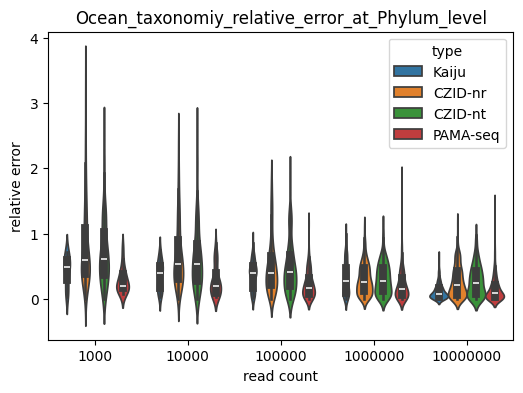

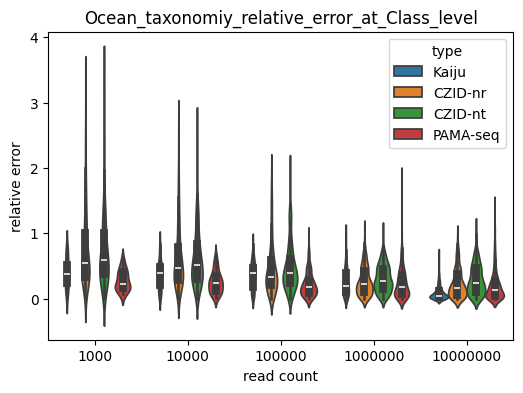

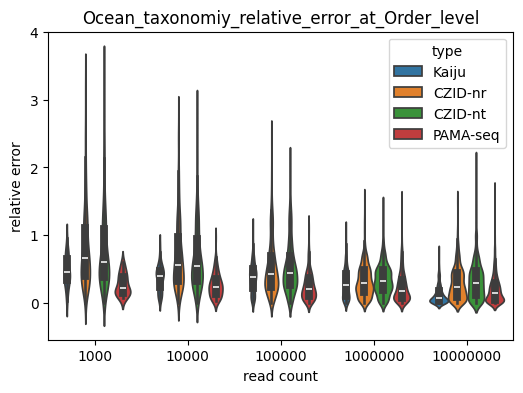

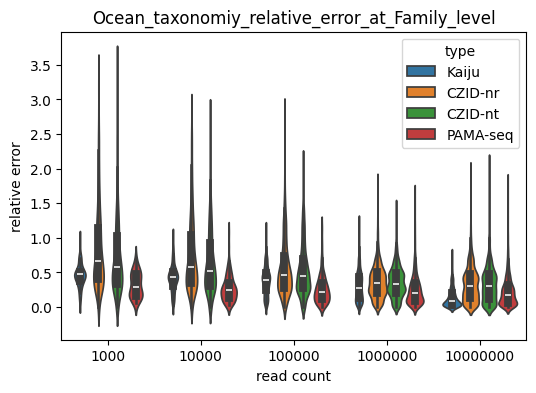

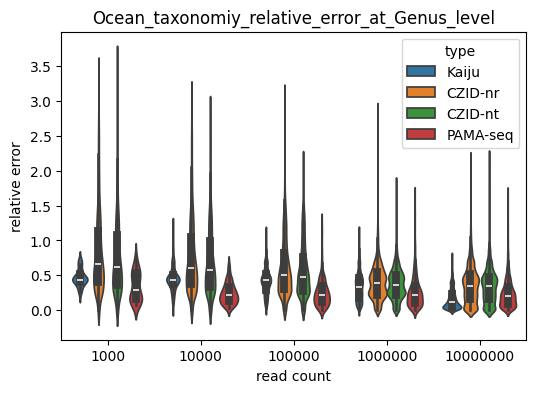

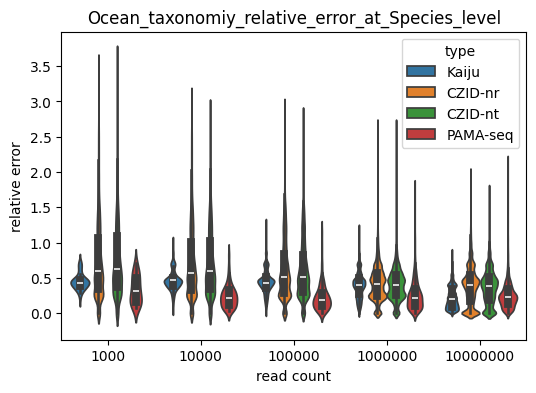

In [323]:
read_cnt_dict = {'1K': 1000, '10K': 10000, '100K': 100000, '1M':1000000, '10M': 10000000}

for t in taxa_up[1:]:
    kaiju_error = pd.read_csv(out_dir + 'kaiju_ocean_{}_relative_error_for_violin_plot.csv'.format(t.lower()), index_col = 0)
    nr_error = pd.read_csv(out_dir+ 'czid_nr_ocean_{}_relative_error_for_violin_plot.csv'.format( t.lower()), index_col = 0)
    nt_error = pd.read_csv(out_dir+ 'czid_nt_ocean_{}_relative_error_for_violin_plot.csv'.format( t.lower()), index_col = 0)
    pam_error = pd.read_csv(out_dir+ 'pam-seq_ocean_{}_relative_error_for_violin_plot.csv'.format(t), index_col = 0)
    #kaiju_error = kaiju_error.rename(columns = {'index': t.lower()})
    pam_error = pam_error.rename(columns = {t:t.lower()})
    
    kaiju_error = kaiju_error.rename(columns = read_cnt_dict)
    kaiju_error = kaiju_error.dropna(axis=0, how='all')
    kaiju_error.index.name = t.lower()
    

    kaiju_error['read count'] = kaiju_error['read count'].map(read_cnt_dict)
    
    kaiju_error['type'] = 'Kaiju'
    nr_error['type'] = 'CZID-nr'
    nt_error['type'] = 'CZID-nt'
    pam_error['type'] = 'PAMA-seq'

    combined_df = pd.concat([kaiju_error, nr_error, nt_error, pam_error], axis=0)
    combined_df = combined_df.reset_index(drop=True)
    combined_df = combined_df[(combined_df['relative error'] != 0) & (~combined_df['relative error'].isna())]
    combined_df.to_csv(out_dir + 'ocean_{}_level_error_combined_all.csv'.format(t))

    plt.figure(figsize=(6,4))
    sns.violinplot(data = combined_df,
                   x = 'read count',
                   y = 'relative error',
                   hue = 'type',              
              )
    #plt.ylim(0, 1)
    plt.title('Ocean_taxonomiy_relative_error_at_{}_level'.format(t))
    plt.savefig(out_dir+'ocean_{}_relative_error_combined_violin.pdf'.format(t,), )
    plt.show()

    

#### Shannon index

In [ ]:
cmb_rel_by_read_cnt.to_csv(out_dir + '{}_pam-seq_combined_relative_abundance_by_read_count.csv'.format(t))

index read count  relative error
0                  Proteobacteria       1000    8.318654e-03
1                   Bacteroidetes       1000    7.956130e-03
2                 Bacillariophyta       1000    4.335897e-03
3                  Actinobacteria       1000    7.071068e-04
4                     Chlorophyta       1000    1.825742e-03
..                            ...        ...             ...
990  Candidatus Eremiobacteraeota   10000000    8.164966e-08
991  Candidatus Nanohaloarchaeota   10000000    1.258306e-07
992   Candidatus Chisholmbacteria   10000000    1.000000e-07
993   Candidatus Gribaldobacteria   10000000    9.574271e-08
994      Candidatus Parvarchaeota   10000000    5.000000e-08

[995 rows x 3 columns]

In [221]:
pam_error

phylum  read count  relative error
0                     Streptophyta        1000        0.075797
1                   Pseudomonadota        1000        0.071062
2                     Foraminifera        1000        0.163056
3                              SAR        1000        0.198358
4                   Proteobacteria        1000        0.162435
...                            ...         ...             ...
1380                 Parvarchaeota    10000000        0.000000
1381                   Brachiopoda    10000000             NaN
1382                      RsaHf231    10000000        0.000000
1383     Candidatus Kuenenbacteria    10000000             NaN
1384  uncultured dinoflagellate       10000000             NaN

[1385 rows x 3 columns]

In [151]:
czi_dir = '/home/xiangpeng/projects/16S_18S/ocean/ocean_meta/czi/output/'
kaiju_dir = '/home/xiangpeng/projects/16S_18S/ocean/ocean_meta/ocean_subsample_kaiju/output/'

In [152]:
read_cnt_dict = {'1K': 1000, '10K': 10000, '100K': 100000, '1M':1000000, '10M': 10000000}

for t in taxa[1:]:
    kaiju_error = pd.read_csv(kaiju_dir + 'kaiju_ocean_{}_relative_error_for_violin_plot.csv'.format(t.lower()), index_col = 0)
    nr_error = pd.read_csv(czi_dir+ 'czi_ocean_{}_relative_error_for_violin_plot_nr.csv'.format(t.lower()), index_col = 0)
    nt_error = pd.read_csv(czi_dir+ 'czi_ocean_{}_relative_error_for_violin_plot_nt.csv'.format(t.lower()), index_col = 0)
    pam_error = pd.read_csv(out_dir+ 'pam-seq_ocean_{}_relative_error_for_violin_plot.csv'.format(t), index_col = 0)
    kaiju_error = kaiju_error.rename(columns = {'index': t.lower()})
    kaiju_error['read count'] = kaiju_error['read count'].map(read_cnt_dict) 
    
    pam_error = pam_error.rename(columns = {t: t.lower()})
    
    kaiju_error['type'] = 'Kaiju'
    nr_error['type'] = 'CZID-nr'
    nt_error['type'] = 'CZID-nt'
    pam_error['type'] = 'PAM-seq'

    combined_df = pd.concat([kaiju_error, nr_error, nt_error, pam_error], axis=0)
    combined_df = combined_df.reset_index(drop=True)
    combined_df.to_csv(out_dir + 'ocean_{}_level_error_combined_all.csv'.format(t))

    plt.figure(figsize=(6,4))
    sns.violinplot(data = combined_df,
                   x = 'read count',
                   y = 'relative error',
                   hue = 'type',              
              )
    #plt.ylim(0, 1)
    plt.title('Ocean_taxonomiy_relative_error_at_{}_level'.format(t))
    plt.savefig(out_dir+'ocean_{}_relative_error_combined_violin.pdf'.format(t,), )
    plt.show()

    
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/xiangpeng/projects/16S_18S/code_for_github/output/ocean_subsample/pam-seq_ocean_class_relative_error_for_violin_plot.csv'

In [72]:
read_cnt_dict = {'1K': '1000', '10K': '10000', '100K': '100000', '1M':'1000000', '10M': '10000000'}

for t in taxa[1:]:
    kaiju_taxa_cnt = pd.read_csv(kaiju_dir + 'ocean_kaiju_{}_level_taxa_count.csv'.format(t.lower()), index_col = 0)
    kaiju_taxa_cnt_err = pd.read_csv(kaiju_dir + 'ocean_kaiju_{}_level_taxa_count_error.csv'.format(t.lower()), index_col = 0)
    kaiju_taxa_cnt = kaiju_taxa_cnt.rename(columns = read_cnt_dict)
    kaiju_taxa_cnt_err = kaiju_taxa_cnt_err.rename(columns = read_cnt_dict)

    nr_taxa_cnt = pd.read_csv(czi_dir+ 'ocean_czi_{}_level_taxa_count_nr.csv'.format(t.lower()), index_col = 0)
    nr_taxa_cnt_err = pd.read_csv(czi_dir+ 'ocean_czi_{}_level_taxa_count_error_nr.csv'.format(t.lower()), index_col = 0)
    
    nt_taxa_cnt = pd.read_csv(czi_dir+ 'ocean_czi_{}_level_taxa_count_nt.csv'.format(t.lower()), index_col = 0)
    nt_taxa_cnt_err = pd.read_csv(czi_dir+ 'ocean_czi_{}_level_taxa_count_error_nt.csv'.format(t.lower()), index_col = 0)

    pam_taxa_cnt = pd.read_csv(out_dir + 'ocean_pam_{}_level_taxa_count.csv'.format(t), index_col = 0)
    pam_taxa_cnt_err = pd.read_csv(out_dir + 'ocean_pam_{}_level_taxa_count_error.csv'.format(t), index_col = 0)

    # Combine DataFrames and Errors
    data_combined = pd.concat([kaiju_taxa_cnt, nr_taxa_cnt, nt_taxa_cnt, pam_taxa_cnt], keys=['Kaiju', 'CZID-nr', 'CZID-nt', 'PAM-seq'])
    error_combined = pd.concat([kaiju_taxa_cnt_err, nr_taxa_cnt_err, nt_taxa_cnt_err, pam_taxa_cnt_err], keys=['Kaiju', 'CZID-nr', 'CZID-nt', 'PAM-seq'])

    # Reshape Data
    data_long = data_combined.reset_index(level=0).melt(id_vars='level_0', var_name='Category', value_name='Value')
    error_long = error_combined.reset_index(level=0).melt(id_vars='level_0', var_name='Category', value_name='Error')

    # Merge Data and Errors
    plot_data = pd.merge(data_long, error_long, on=['level_0', 'Category'])

    # Plotting
    categories = plot_data['Category'].unique()
    x = np.arange(len(categories))  # X positions for groups
    width = 0.2  # Width of the bars

    fig, ax = plt.subplots(figsize=(6, 4))

    # Create grouped bar plot
    for i, label in enumerate(['Kaiju', 'CZID-nr', 'CZID-nt', 'PAM-seq']):
        subset = plot_data[plot_data['level_0'] == label]
        ax.bar(x + i * width, subset['Value'], width=width, yerr=subset['Error'], label=label, capsize=5)

    # Customize plot
    ax.set_xlabel('Read Depth')
    ax.set_ylabel('{} Counts'.format(t))
    ax.set_title('Detected {} counts'.format(t))
    ax.set_xticks(x + width)
    ax.set_xticklabels(categories)
    ax.legend()

    plt.tight_layout()
    
    plt.savefig(out_dir+'ocean_{}_count_at_different_seq_depth.pdf'.format(t,), )
    plt.show()
    
    

FileNotFoundError: [Errno 2] No such file or directory: '/home/xiangpeng/projects/16S_18S/code_for_github/output/ocean_subsample/ocean_pam_Phylum_level_taxa_count.csv'

## Combine subsamples by their taxon names

### PAM-seq data

In [22]:
read_cnts = [1000, 1000,1000, 1000,1000, 
             10000, 10000,10000,10000,10000,
             100000, 100000, 100000, 100000, 100000, 
             1000000, 1000000,1000000,1000000,1000000,
             10000000,10000000,10000000,10000000,10000000,
            ]
taxon_col = ['ASV', 'Kingdom', 'Phylum', 'Class',
       'Order', 'Family', 'Genus', 'Species', 'Full_Taxon', 'Sequence']

ocean_cols = ['ocean_combined_1000_1',
 'ocean_combined_1000_2',
 'ocean_combined_1000_3',
 'ocean_combined_1000_4',
 'ocean_combined_1000_5',
 'ocean_combined_10000_1',
 'ocean_combined_10000_2',
 'ocean_combined_10000_3',
 'ocean_combined_10000_4',
 'ocean_combined_10000_5',
 'ocean_combined_100000_1',
 'ocean_combined_100000_2',
 'ocean_combined_100000_3',
 'ocean_combined_100000_4',
 'ocean_combined_100000_5',
 'ocean_combined_1000000_1',
 'ocean_combined_1000000_2',
 'ocean_combined_1000000_3',
 'ocean_combined_1000000_4',
 'ocean_combined_1000000_5',
 'ocean_combined_10000000_1',
 'ocean_combined_10000000_2',
 'ocean_combined_10000000_3',
 'ocean_combined_10000000_4',
 'ocean_combined_10000000_5']

In [23]:
pam_rel_filtered = pam_filtered[ocean_cols].div(read_cnts)
pam_rel_filtered[taxon_col] = pam_filtered[taxon_col]

In [24]:
pam_rel_filtered

ocean_combined_1000_1  ocean_combined_1000_2  ocean_combined_1000_3  \
10394                    0.0                    0.0                    0.0   
6123                     0.0                    0.0                    0.0   
14272                    0.0                    0.0                    0.0   
17825                    0.0                    0.0                    0.0   
12115                    0.0                    0.0                    0.0   
...                      ...                    ...                    ...   
37742                    0.0                    0.0                    0.0   
37754                    0.0                    0.0                    0.0   
37760                    0.0                    0.0                    0.0   
37782                    0.0                    0.0                    0.0   
37820                    0.0                    0.0                    0.0   

       ocean_combined_1000_4  ocean_combined_1000_5  ocean_combined_10000_1  \
10394                    0.0                    0.0                     0.0   
6123                     0.0                    0.0                     0.0   
14272                    0.0                    0.0                     0.0   
17825                    0.0                    0.0                     0.0   
12115                    0.0                    0.0                     0.0   
...                      ...                    ...                     ...   
37742                    0.0                    0.0                     0.0   
37754                    0.0                    0.0                     0.0   
37760                    0.0                    0.0                     0.0   
37782                    0.0                    0.0                     0.0   
37820                    0.0                    0.0                     0.0   

       ocean_combined_10000_2  ocean_combined_10000_3  ocean_combined_10000_4  \
10394                     0.0                     0.0                     0.0   
6123                      0.0                     0.0                     0.0   
14272                     0.0                     0.0                     0.0   
17825                     0.0                     0.0                     0.0   
12115                     0.0                     0.0                     0.0   
...                       ...                     ...                     ...   
37742                     0.0                     0.0                     0.0   
37754                     0.0                     0.0                     0.0   
37760                     0.0                     0.0                     0.0   
37782                     0.0                     0.0                     0.0   
37820                     0.0                     0.0                     0.0   

       ocean_combined_10000_5  ...                               ASV  \
10394                     0.0  ...  1fc702b2cf995509b3a91e8cea2f3224   
6123                      0.0  ...  87e136ad633cf09f5f51276411939ae4   
14272                     0.0  ...  bd01a266418f8e275d83afb23d38bd69   
17825                     0.0  ...  8471dd95f3ca8f172602ca90ffb153d0   
12115                     0.0  ...  80894c43ace63e5099e56bb49cfb4e35   
...                       ...  ...                               ...   
37742                     0.0  ...  3fee5f6224ba5b907ec4171832084b19   
37754                     0.0  ...  61806e9f8244a990926623373c7895a8   
37760                     0.0  ...  5427be8de3c18c3e2d9fc1f2f42e9a3f   
37782                     0.0  ...  34373fe9321b843983ffdaa673a7a72d   
37820                     0.0  ...  4219d713bfd55beee0b6a44897f5b7e3   

         Kingdom             Phylum                Class               Order  \
10394   Bacteria          Bacillota              Bacilli          Bacillales   
6123    Bacteria     Pseudomonadota  Gammaproteobacteria     Pseudomonadales   
14272   Bacteria     Pseudomonadota  Gammap

Phylum (507, 99)


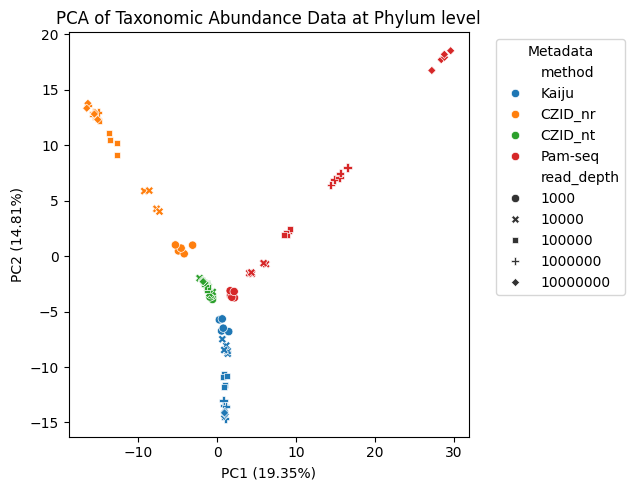

Class (767, 99)


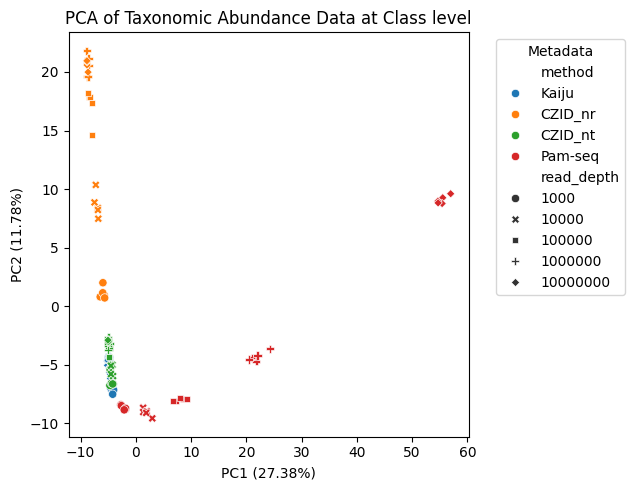

Order (1728, 99)


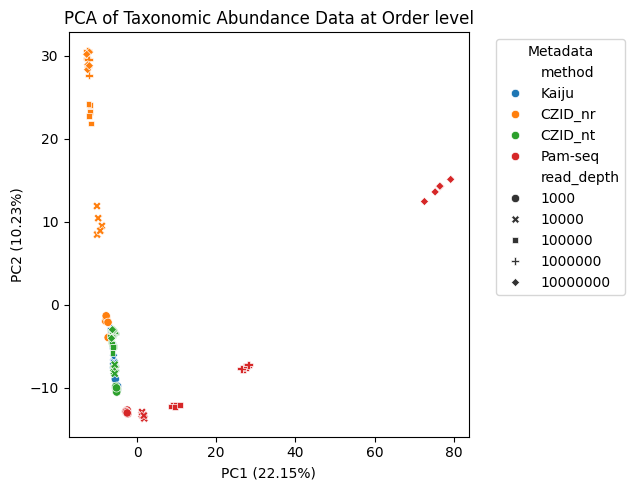

Family (4384, 99)


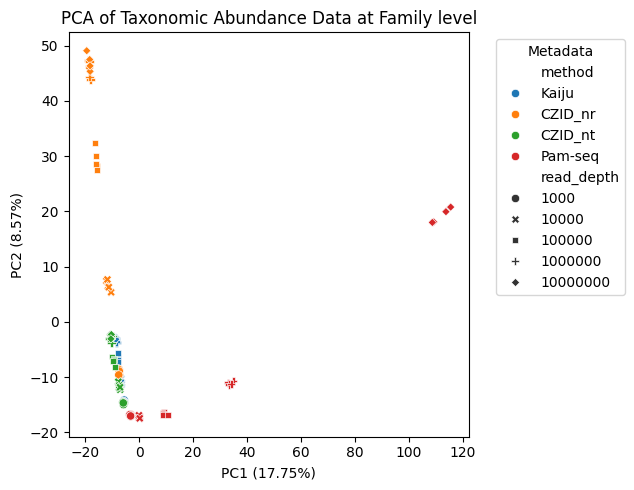

Genus (11903, 99)


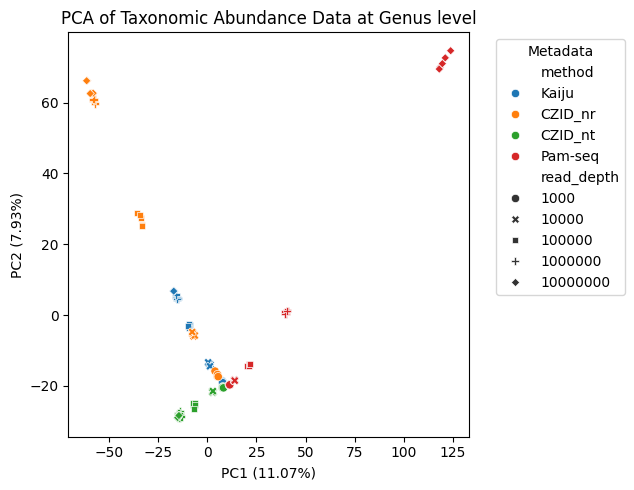

Species (62657, 99)


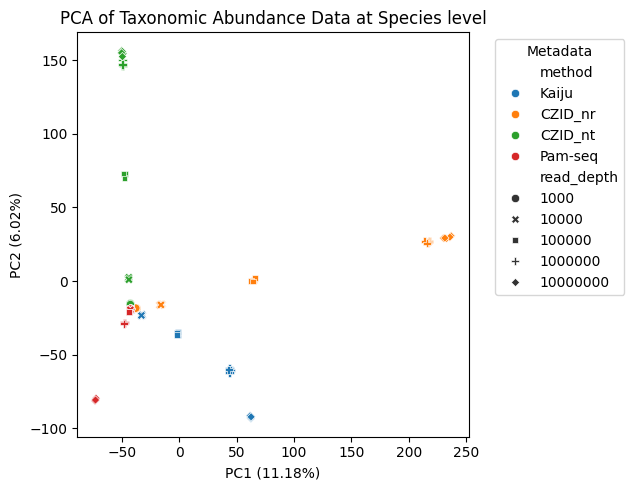

In [25]:
# plot the taxon counts, total abundance, and the relative errors. 
metadata = pd.read_csv(out_dir+ 'all_method_combined_df_metadata.csv', index_col=0)
for t in taxa[1:]:
    # load data by the taxon
    pam_cmb_df =  pd.read_csv(out_dir + 'ocean_pam_subsample_read_cnt_by_{}.csv'.format(t), index_col = 0 ) 
    kaiju_cmb_df  = pd.read_csv(kaiju_dir + 'ocean_{}_level_kaiju_read_counts.csv'.format(t.lower()), index_col = 0)   
    kaiju_cmb_df=kaiju_cmb_df.drop(columns = ['taxon_id'])
    kaiju_cmb_df = kaiju_cmb_df/kaiju_cmb_df.sum()
    kaiju_cmb_df = kaiju_cmb_df.drop(index = ['cannot be assigned to a (non-viral) {}'.format(t.lower()), 'unclassified'])
    kaiju_cmb_df.columns = kaiju_cmb_df.columns.str.replace(t.lower(), 'kaiju')
    nr_cmb_df  = pd.read_csv(czi_dir+ '{}_czid_combined_relative_abundance_nr.csv'.format(t.lower()), index_col = 0)
    nt_cmb_df = pd.read_csv(czi_dir+ '{}_czid_combined_relative_abundance_nt.csv'.format(t.lower()), index_col = 0)
    rel_abd_all_methods = pd.concat([kaiju_cmb_df, nr_cmb_df, nt_cmb_df, pam_cmb_df], axis =1)
    rel_abd_all_methods = rel_abd_all_methods.fillna(0) # fill empty space with 0
    rel_abd_all_methods = rel_abd_all_methods[~rel_abd_all_methods.index.str.startswith(('uncultured', 'unidentified', 'unclassified'))] # remove unclutured or unidentified taxon

    rel_abd_all_methods.to_csv(out_dir+ 'ocean_sub_sample_all_method_combined_at_{}_taxa_level.csv'.format(t))
    print(t, rel_abd_all_methods.shape)
    # pca analysis at different taxon level

    # Normalize to relative abundance
    taxa_abundance = rel_abd_all_methods.T
    relative_abundance = rel_abd_all_methods.T

    # Log-transform the data
    log_transformed = np.log1p(relative_abundance)

    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(log_transformed)

    # PCA
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(standardized_data)

    # Create a DataFrame for PCA results
    pca_results = pd.DataFrame(
                    principal_components, 
                    columns=["PC1", "PC2"], 
                    index=taxa_abundance.index
                    )

    # Combine PCA results with metadata
    pca_combined = pca_results.merge(metadata, left_index=True, right_index=True)

    # Plot PCA
    plt.figure(figsize=(6.5,5))
    sns.scatterplot(
            data=pca_combined,
            x="PC1", y="PC2",
            hue="method",  # Color by location
           #size="Read_Depth",  # Size by read depth
            #sizes=(50, 300),
            style="read_depth",  # Optional: Style by location
            #palette="Set2"
                )

    # Add labels and title
    plt.title("PCA of Taxonomic Abundance Data at {} level".format(t))
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}%)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}%)")
    plt.legend(title="Metadata", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(out_dir + "PCA_of_Taxonomic_Abundance_at_{}_level.pdf".format(t))
    plt.show()



    

## Alpha Diversity Analysis

/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/util/_warning.py:60: UserWarning: observed_otus is deprecated as of 0.6.0.
  warn(f"{func.__name__} is deprecated as of {ver}.")


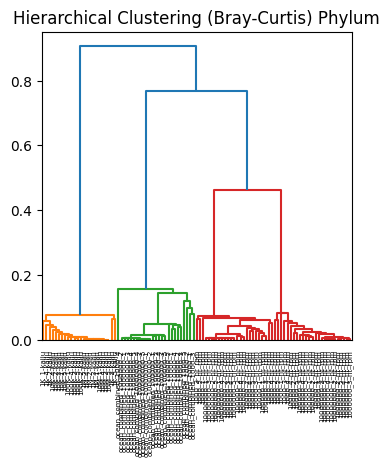

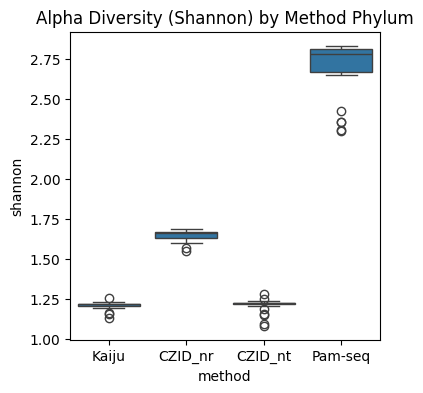

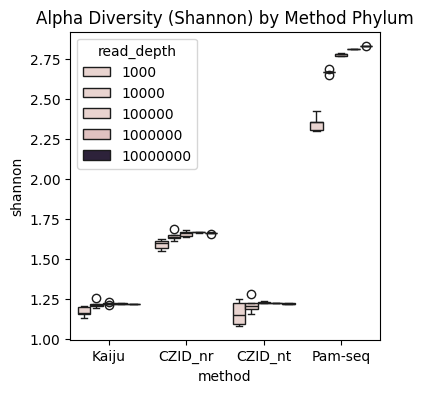

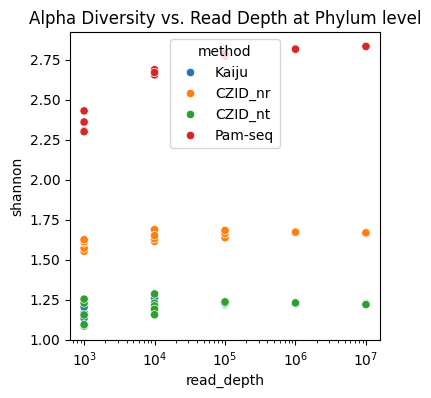

ANOVA result: F_onewayResult(statistic=np.float64(1266.4755928607224), pvalue=np.float64(1.926454578721102e-76))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.20275556835602324), pvalue=np.float64(0.04414322908887413))
ANOSIM result for Method: method name               ANOSIM
test statistic name            R
sample size                   99
number of groups               4
test statistic               1.0
p-value                    0.001
number of permutations       999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.02305806614135933), np.float64(0.188), 99)
Mantel test result: (np.float64(-0.02305806614135933), np.float64(0.178), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.01837870345784532 and the largest is 14.171883642992341.
  warn(


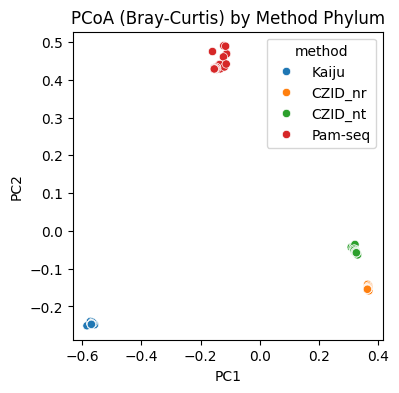

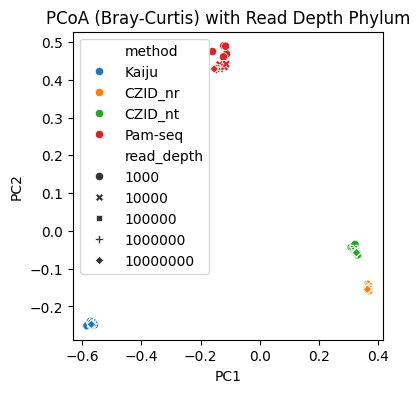

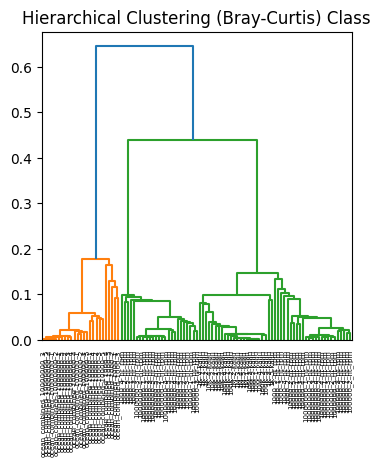

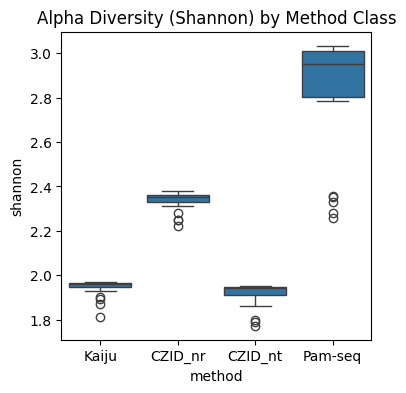

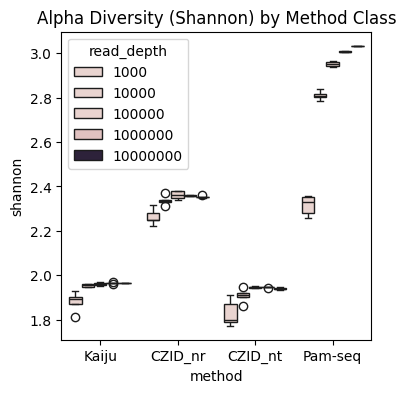

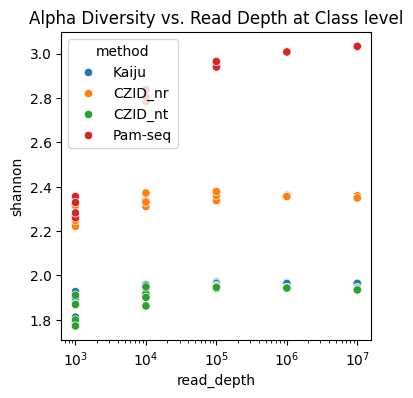

ANOVA result: F_onewayResult(statistic=np.float64(223.06499984844106), pvalue=np.float64(7.172775859060728e-43))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.30485919272706624), pvalue=np.float64(0.002153720291626451))
ANOSIM result for Method: method name                 ANOSIM
test statistic name              R
sample size                     99
number of groups                 4
test statistic            0.971587
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.01686598391860812), np.float64(0.611), 99)
Mantel test result: (np.float64(-0.01686598391860812), np.float64(0.643), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.018749861561325545 and the largest is 6.929455961855646.
  warn(


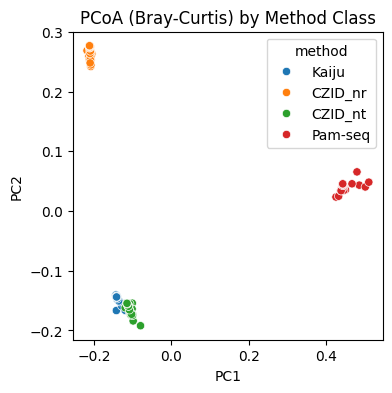

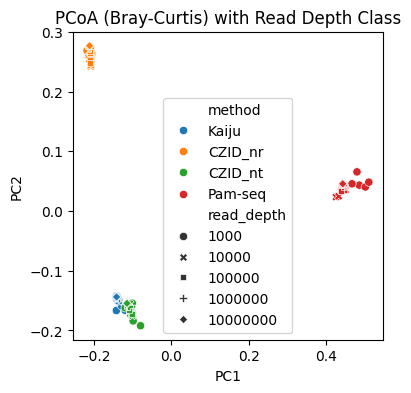

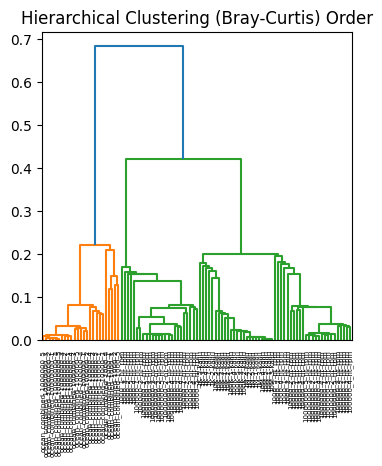

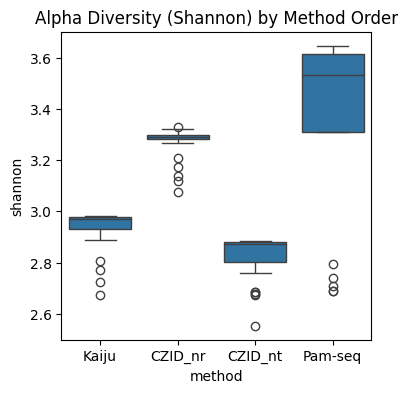

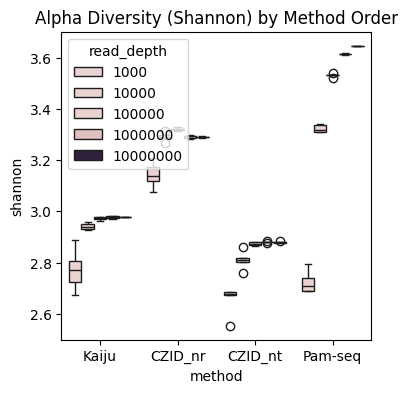

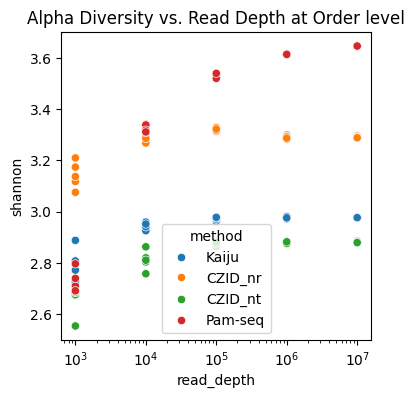

ANOVA result: F_onewayResult(statistic=np.float64(48.10601659914343), pvalue=np.float64(5.343607524622288e-19))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.43350963320150343), pvalue=np.float64(7.386540684994855e-06))
ANOSIM result for Method: method name                 ANOSIM
test statistic name              R
sample size                     99
number of groups                 4
test statistic            0.962966
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.024258988720593653), np.float64(0.515), 99)
Mantel test result: (np.float64(-0.024258988720593653), np.float64(0.507), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.024401484830195393 and the largest is 7.745771120446724.
  warn(


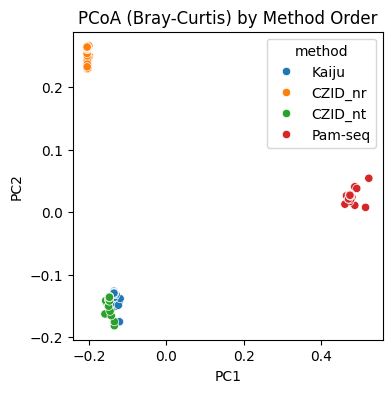

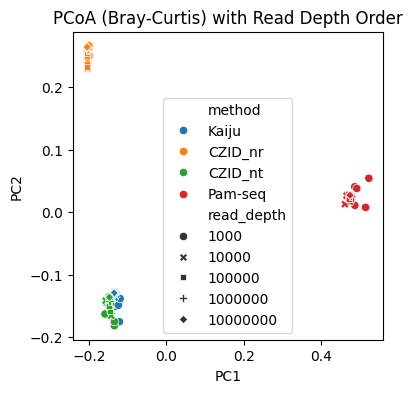

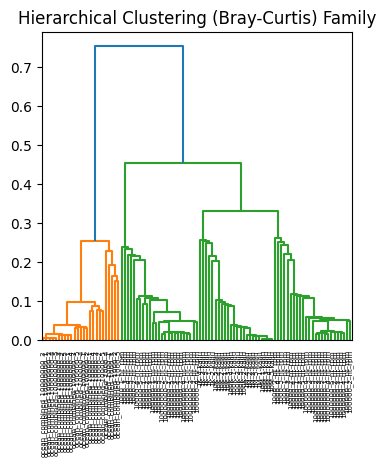

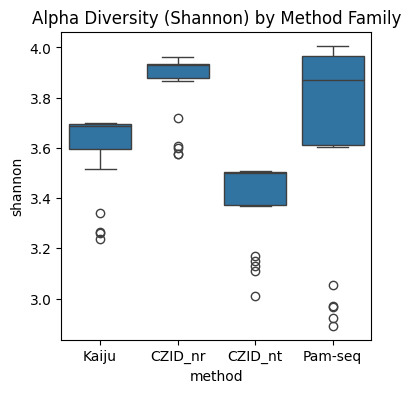

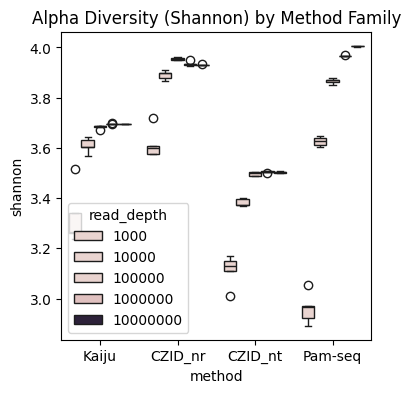

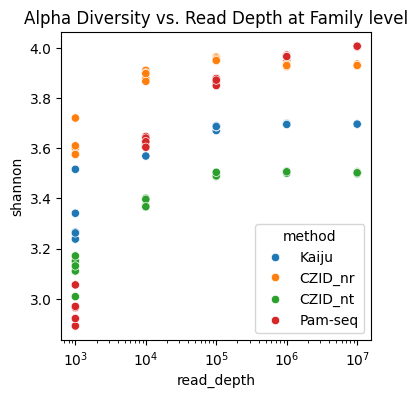

ANOVA result: F_onewayResult(statistic=np.float64(16.776747183980035), pvalue=np.float64(7.98223450691287e-09))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.5790500593850902), pvalue=np.float64(3.4181395853208357e-10))
ANOSIM result for Method: method name                 ANOSIM
test statistic name              R
sample size                     99
number of groups                 4
test statistic            0.998725
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.035677578048610964), np.float64(0.272), 99)
Mantel test result: (np.float64(-0.035677578048610964), np.float64(0.286), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03908915256529892 and the largest is 9.230426705331865.
  warn(


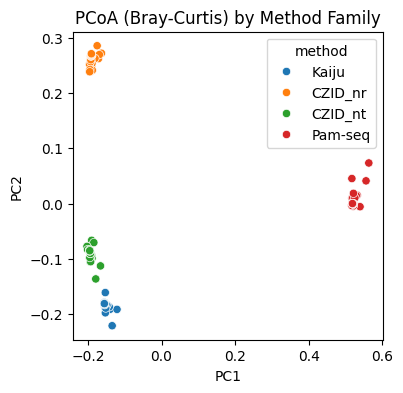

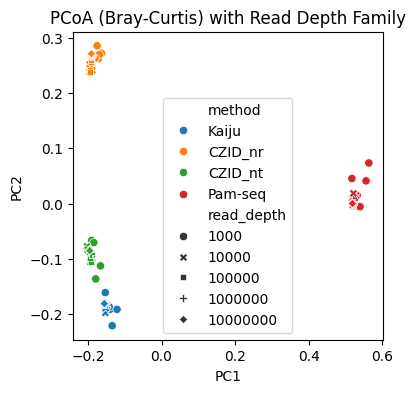

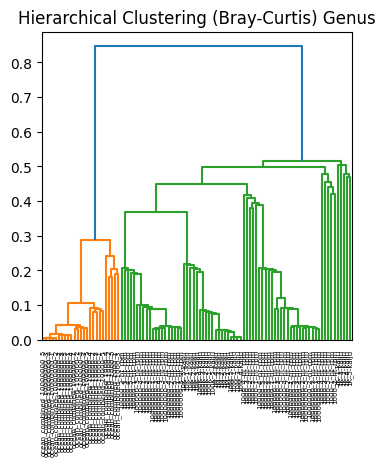

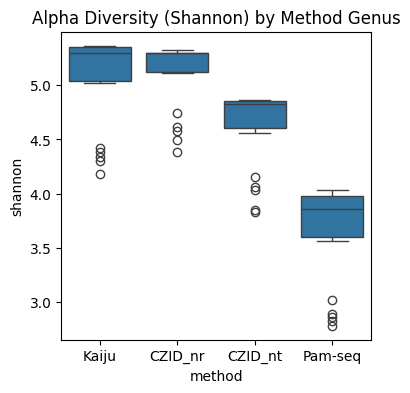

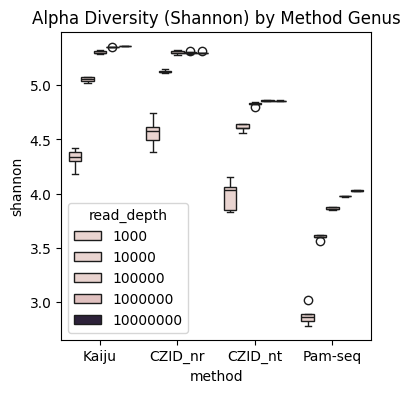

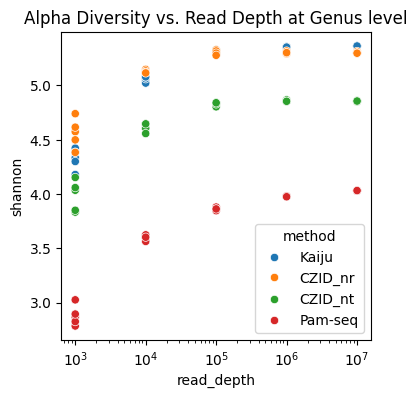

ANOVA result: F_onewayResult(statistic=np.float64(79.7124671561865), pvalue=np.float64(7.564239315060379e-26))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.46528881034857655), pvalue=np.float64(1.2193148584852824e-06))
ANOSIM result for Method: method name                 ANOSIM
test statistic name              R
sample size                     99
number of groups                 4
test statistic            0.902282
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.05720759203546154), np.float64(0.089), 99)
Mantel test result: (np.float64(-0.05720759203546154), np.float64(0.088), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.015864607502944612 and the largest is 11.584900146223637.
  warn(


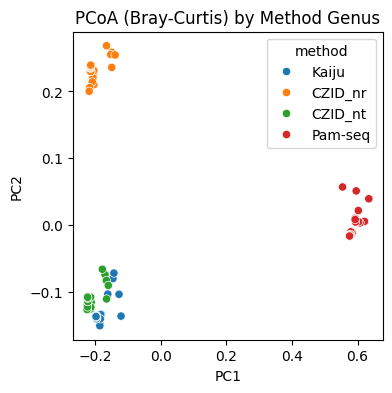

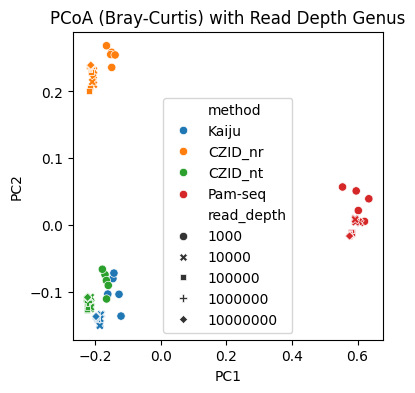

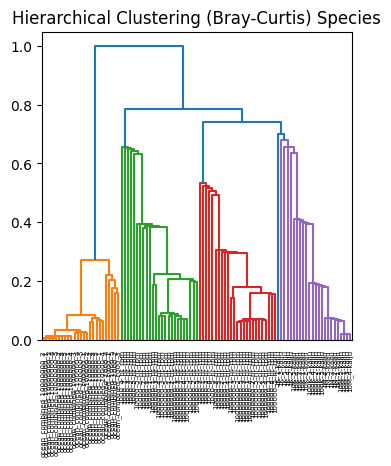

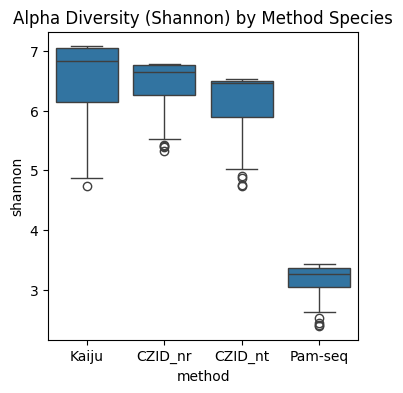

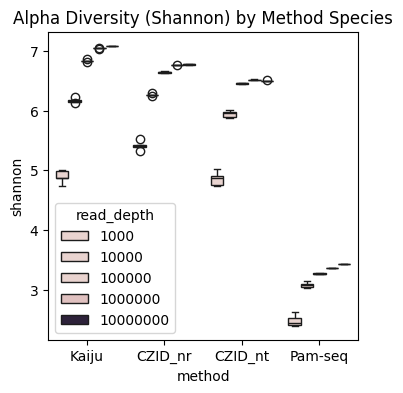

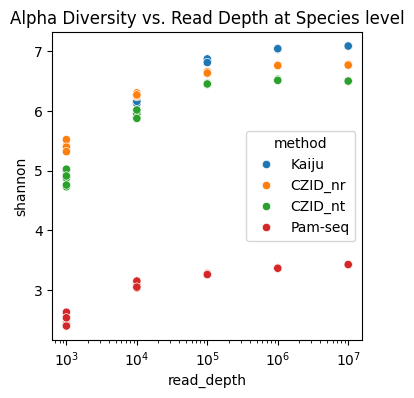

ANOVA result: F_onewayResult(statistic=np.float64(162.6202958175961), pvalue=np.float64(2.7163099324566562e-37))
Spearman Correlation: SignificanceResult(statistic=np.float64(0.5213299849044578), pvalue=np.float64(3.153937867353662e-08))
ANOSIM result for Method: method name                 ANOSIM
test statistic name              R
sample size                     99
number of groups                 4
test statistic            0.988894
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object
Mantel test result: (np.float64(-0.055141028751248065), np.float64(0.015), 99)
Mantel test result: (np.float64(-0.055141028751248065), np.float64(0.016), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0029084855849922124 and the largest is 14.233630011776118.
  warn(


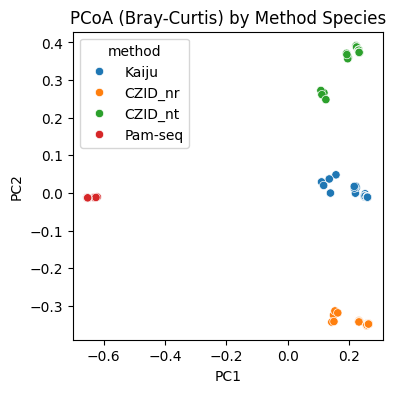

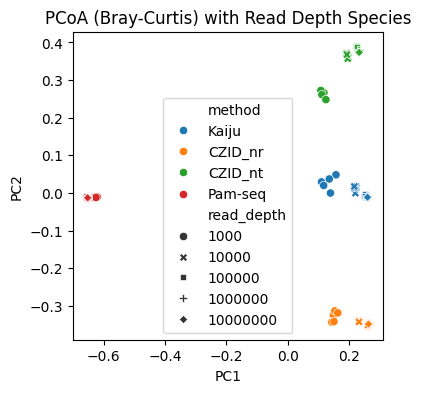

In [26]:
# plot the taxon counts, total abundance, and the relative errors. 
metadata = pd.read_csv(out_dir+ 'all_method_combined_df_metadata.csv', index_col=0)
for t in taxa[1:]:
    # load data by the taxon
    
    rel_abd_all_methods=pd.read_csv(out_dir+ 'ocean_sub_sample_all_method_combined_at_{}_taxa_level.csv'.format(t), index_col=0)
    df_taxa = rel_abd_all_methods.T
    df_meta = metadata
    df_taxa.index.name = 'Sample'
    df_meta.index.name = 'Sample'
    
    
    ### Analyze Alpha Diversity Across Metadata Parameters
    # Choose metric: 'shannon', 'simpson', 'observed_otus' (richness)
    alpha_metrics = ['shannon', 'simpson', 'observed_otus']

    # Calculate alpha diversity for each sample
    alpha_results = {metric: alpha_diversity(metric, df_taxa.values, df_taxa.index)
                     for metric in alpha_metrics}

    # Convert results to a DataFrame
    df_alpha = pd.DataFrame(alpha_results, index=df_taxa.index)
    


    # Compute Bray-Curtis distance matrix
    beta_metric = 'braycurtis'
    dist_matrix = beta_diversity(beta_metric, df_taxa.values, df_taxa.index)

    # Convert to a DataFrame
    df_dist = pd.DataFrame(dist_matrix.data, index=df_taxa.index, columns=df_taxa.index)
    

    # Visualize as a dendrogram
    plt.figure(figsize=(4,4))
    linkage_matrix = linkage(dist_matrix.condensed_form(), method='average')
    dendrogram(linkage_matrix, labels=df_taxa.index)
    plt.title('Hierarchical Clustering (Bray-Curtis) {}'.format(t))
    plt.savefig(out_dir+'HierarchicalClustering_{}.pdf'.format(t))
    plt.show()

    # Map metadata to sample IDs
    grouping = df_meta['method']

    # Perform ANOSIM test
    anosim_result = anosim(dist_matrix, grouping)
    # Example alpha diversity DataFrame
    df_alpha_meta = df_alpha.merge(df_meta, left_index=True, right_index=True)

    # Boxplot for Method
    plt.figure(figsize=(4,4))
    sns.boxplot(data=df_alpha_meta, x='method', y='shannon')
    plt.title('Alpha Diversity (Shannon) by Method {}'.format(t))
    plt.savefig(out_dir+'AlphaDiversityByMethodat_{}.pdf'.format(t))
    plt.show()
     # Boxplot for Method
    plt.figure(figsize=(4,4))
    sns.boxplot(data=df_alpha_meta, x='method', y='shannon', hue='read_depth')
    plt.title('Alpha Diversity (Shannon) by Method {}'.format(t))
    plt.savefig(out_dir+'AlphaDiversityByMethod_readdepth_at_{}.pdf'.format(t))
    plt.show()

    # Scatter plot for Read Depth
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=df_alpha_meta, x='read_depth', y='shannon', hue='method')
    plt.title('Alpha Diversity vs. Read Depth at {} level'.format(t))
    plt.xscale('log')
    plt.savefig(out_dir+'AlphaDiversity_by_read_depth_at_{}.pdf'.format(t))
    plt.show()

    ### Statistical Testing for Alpha Diversity

    # ANOVA for Method
    groups = [group['shannon'].values for _, group in df_alpha_meta.groupby('method')]
    anova_result = f_oneway(*groups)
    print('ANOVA result:', anova_result)

    # Spearman correlation with Read_Depth
    corr_result = spearmanr(df_alpha_meta['read_depth'], df_alpha_meta['shannon'])
    print('Spearman Correlation:', corr_result)


    ###  Analyze Beta Diversity Across Metadata Parameters
    
    # Grouping by Method
    grouping_method = df_meta['method']

    # Perform ANOSIM for Method
    anosim_result_method = anosim(dist_matrix, grouping_method)
    print('ANOSIM result for Method:', anosim_result_method)
    
    # Generate a distance matrix for Read Depth
    read_depth_matrix = np.abs(df_meta['read_depth'].values[:, None] - df_meta['read_depth'].values)



    # Create DistanceMatrix for read_depth_matrix
    read_depth_dist_matrix = DistanceMatrix(read_depth_matrix, ids=df_meta.index)

    # Perform Mantel test
    mantel_result = mantel(dist_matrix, read_depth_dist_matrix)
    print('Mantel test result:', mantel_result)
    
    # Create DistanceMatrix for read_depth_matrix
    read_depth_dist_matrix = DistanceMatrix(read_depth_matrix, ids=df_meta.index)

    # Perform Mantel test
    mantel_result = mantel(dist_matrix, read_depth_dist_matrix)
    print('Mantel test result:', mantel_result)
    
    ### Visualize Beta Diversity with Metadata
    # Perform PCoA on your distance matrix
    pcoa_results = pcoa(dist_matrix)

    # Convert PCoA results to a DataFrame
    df_pcoa = pcoa_results.samples
    # Add metadata to PCoA results
    df_pcoa_meta = df_pcoa.merge(df_meta, left_index=True, right_index=True)

    # Scatter plot for PCoA with Method
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=df_pcoa_meta, x='PC1', y='PC2', hue='method')
    plt.title('PCoA (Bray-Curtis) by Method {}'.format(t))
    plt.savefig(out_dir+'PCoA_by_Method_{}.pdf'.format(t))
    plt.show()
    
    # Scatter plot for PCoA with Read Depth
    plt.figure(figsize=(4,4))
    sns.scatterplot(data=df_pcoa_meta, x='PC1', y='PC2', style='read_depth', hue='method')
    plt.title('PCoA (Bray-Curtis) with Read Depth {}'.format(t))
    plt.savefig(out_dir+'PCoA_by_read_depth_{}.pdf'.format(t))
    plt.show()




   




In [46]:
## what if we only look at the Eukarytic species

<Axes: >

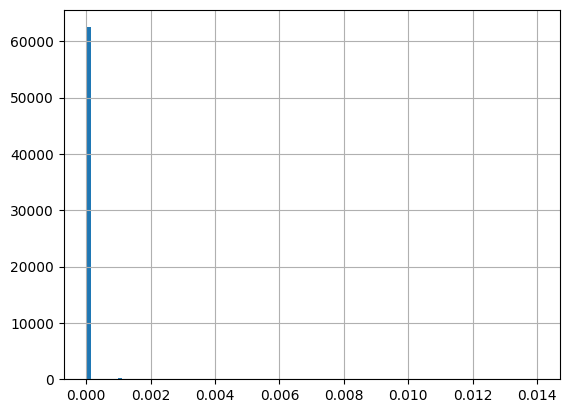

In [47]:
rel_abd_all_methods['1K_1-kaiju'].hist(bins= 100)

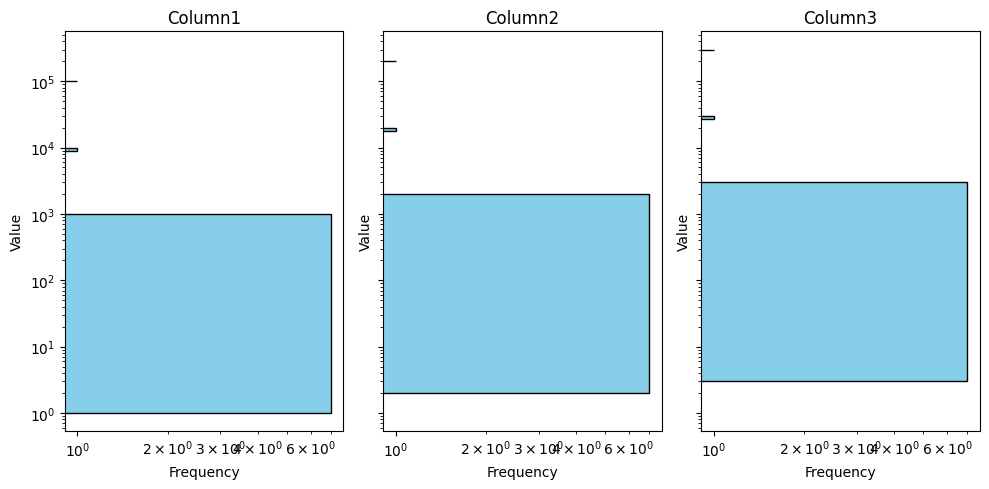

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame
data = {
    'Column1': [1, 2, 3, 4, 5, 100, 1000, 10000, 100000],
    'Column2': [2, 3, 4, 5, 6, 200, 2000, 20000, 200000],
    'Column3': [3, 4, 5, 6, 7, 300, 3000, 30000, 300000]
}
df = pd.DataFrame(data)

# Plot settings
n_cols = df.shape[1]  # Number of columns
fig, axes = plt.subplots(nrows=1, ncols=n_cols, figsize=(10, 5), sharey=True)

for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=100, orientation='horizontal', color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Frequency')
    axes[i].set_ylabel('Value')
    axes[i].set_yscale('log')  # Set the y-axis to log scale
    axes[i].set_xscale('log')  # Set the x-axis to log scale

plt.tight_layout()
plt.show()


# plot the line plots side by side
Order of the method: Kaiju, CZID nt, CZID nr, PAM-seq

Plots:
1. line plot by the read depth (the taxon are color coded by the domain)
2. Count of taxon
3. ratio of read mapped



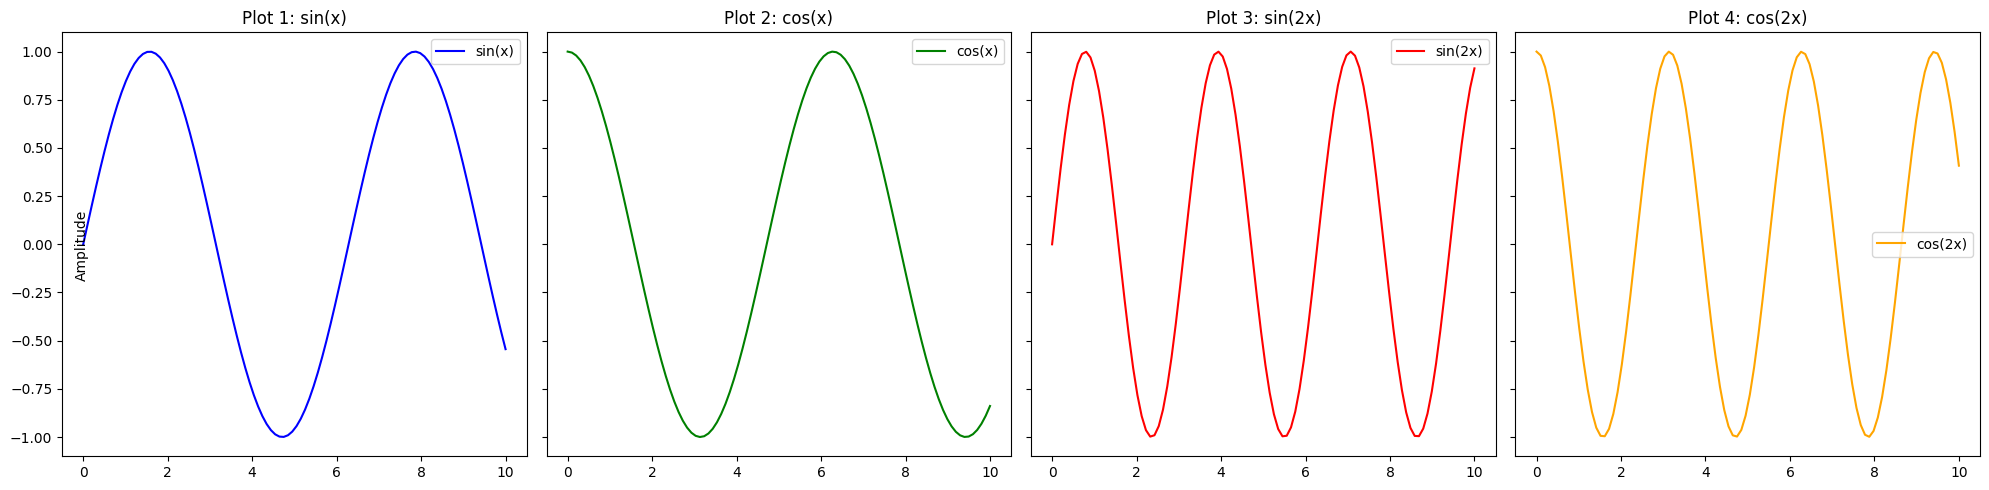

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Generate example data
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.sin(2 * x)
y4 = np.cos(2 * x)

# Create a figure and a row of 4 subplots with shared y-axis
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)  # 1 row, 4 columns, shared y-axis

# Plot data in each subplot
axs[0].plot(x, y1, label="sin(x)", color="blue")
axs[0].set_title("Plot 1: sin(x)")
axs[0].legend()

axs[1].plot(x, y2, label="cos(x)", color="green")
axs[1].set_title("Plot 2: cos(x)")
axs[1].legend()

axs[2].plot(x, y3, label="sin(2x)", color="red")
axs[2].set_title("Plot 3: sin(2x)")
axs[2].legend()

axs[3].plot(x, y4, label="cos(2x)", color="orange")
axs[3].set_title("Plot 4: cos(2x)")
axs[3].legend()

# Add a common y-axis label
fig.text(0.04, 0.5, 'Amplitude', va='center', rotation='vertical')

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_789/2573185155.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$'])
/tmp/ipykernel_789/2573185155.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$'])
/tmp/ipykernel_789/2573185155.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$'])
/tmp/ipykernel_789/2573185155.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$'])


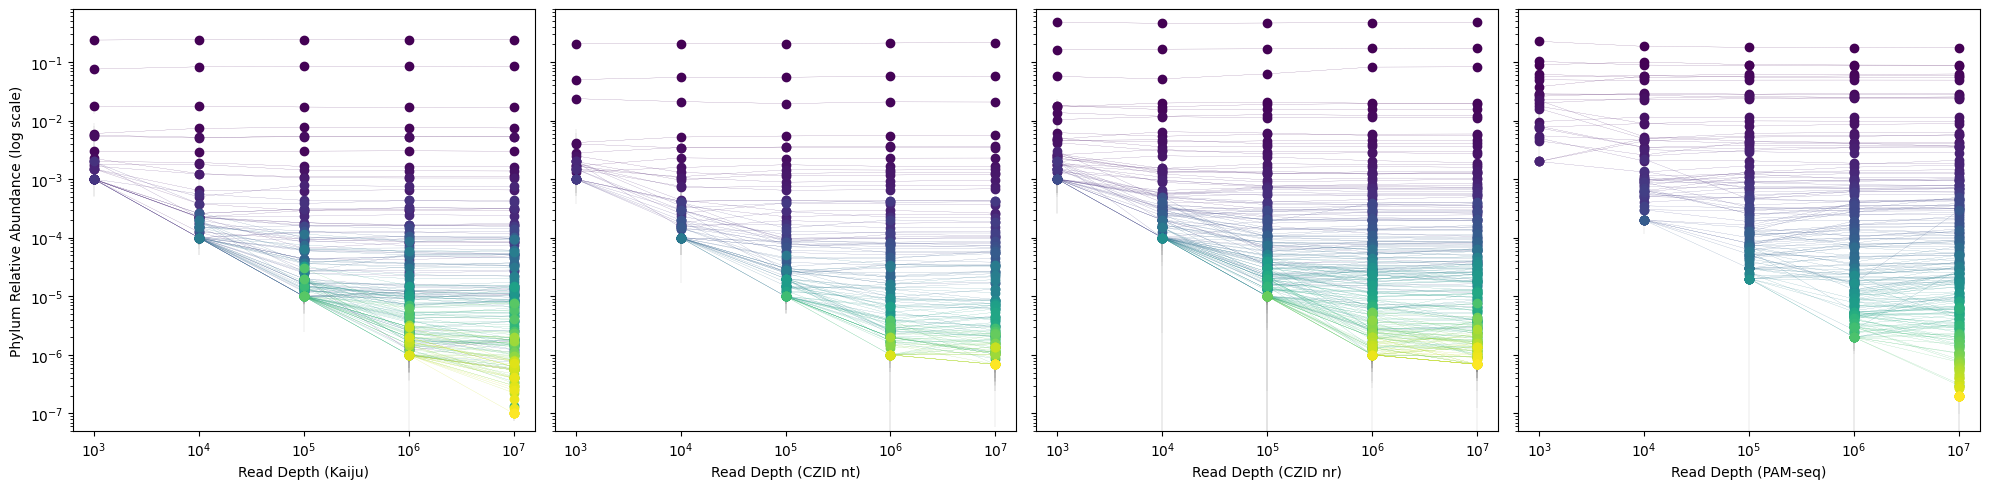

In [10]:

czi_dir = '/home/xiangpeng/projects/16S_18S/ocean/ocean_meta/czi/output/'
kaiju_dir = '/home/xiangpeng/projects/16S_18S/ocean/ocean_meta/ocean_subsample_kaiju/output/'
for t in taxa[1:2]:
    # Create a figure and subplots
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)  # 1 row, 4 columns, shared y-axis
    # plot Kaiju
    cmb_rel_by_read_cnt=pd.read_csv(kaiju_dir + '{}_kaiju_combined_relative_abundance_by_read_count.csv'.format(t.lower()), index_col=0)
    cmb_rel_by_read_cnt_err=pd.read_csv(kaiju_dir + '{}_kaiju_combined_relative_abundance_error_by_read_count.csv'.format(t.lower()), index_col = 0)
     # Use colormap to generate distinct colors for each line
    num_rows = len(cmb_rel_by_read_cnt.index)
    colors = cm.viridis(np.linspace(0, 1, num_rows))

    # Plot on the second subplot (axs[1])
    for i, row in enumerate(cmb_rel_by_read_cnt.index):
        axs[0].errorbar(
            cmb_rel_by_read_cnt.columns,
            cmb_rel_by_read_cnt.loc[row],
            yerr=cmb_rel_by_read_cnt_err.loc[row],
            marker='o',
            label=row,
            color=colors[i],
            ecolor='tab:grey',
            linewidth=0.1,
        )

    # Set properties for the second subplot
    axs[0].set_yscale('log')
    axs[0].set_ylim(0.00000005, 0.8)
    #axs[0].set_title('{} relative abundance (Kaiju)'.format(t,))
    axs[0].set_ylabel('{} Relative Abundance (log scale)'.format(t))
    axs[0].set_xlabel('Read Depth (Kaiju)')

    # plot czid nt
    nr_or_nt = 'nt'
    cmb_rel_by_read_cnt = pd.read_csv(czi_dir  + '{}_czid_combined_relative_abundance_by_read_count_{}.csv'.format(t.lower(), nr_or_nt), index_col=0)
    cmb_rel_by_read_cnt_err = pd.read_csv(czi_dir  + '{}_czid_combined_relative_abundance_error_by_read_count_{}.csv'.format(t.lower(), nr_or_nt), index_col=0)
    min_rel_abd = pd.read_csv(czi_dir  + '{}_czid_minimal_relative_abundance_by_read_count_{}.csv'.format(t.lower(), nr_or_nt), index_col=0)
    total_rel_abd = pd.read_csv(czi_dir  + '{}_czid_total_annotated_relative_abundance_by_read_count_{}.csv'.format(t.lower(), nr_or_nt), index_col=0)

    # Use colormap to generate distinct colors for each line
    num_rows = len(cmb_rel_by_read_cnt.index)
    colors = cm.viridis(np.linspace(0, 1, num_rows))

    # Plot on the second subplot (axs[1])
    for i, row in enumerate(cmb_rel_by_read_cnt.index):
        axs[1].errorbar(
            cmb_rel_by_read_cnt.columns,
            cmb_rel_by_read_cnt.loc[row],
            yerr=cmb_rel_by_read_cnt_err.loc[row],
            marker='o',
            label=row,
            color=colors[i],
            ecolor='tab:grey',
            linewidth=0.1,
        )

    # Set properties for the second subplot
    axs[1].set_yscale('log')
    axs[1].set_ylim(0.00000005, 0.8)
    #axs[1].set_title('{} relative abundance (CZID {})'.format(t, nr_or_nt))
    axs[1].set_xlabel('Read Depth (CZID {})'.format( nr_or_nt))
    #axs[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=3)

    # plot czid nr
    nr_or_nt = 'nr'
    cmb_rel_by_read_cnt = pd.read_csv(czi_dir  + '{}_czid_combined_relative_abundance_by_read_count_{}.csv'.format(t.lower(), nr_or_nt), index_col=0)
    cmb_rel_by_read_cnt_err = pd.read_csv(czi_dir  + '{}_czid_combined_relative_abundance_error_by_read_count_{}.csv'.format(t.lower(), nr_or_nt), index_col=0)
    min_rel_abd = pd.read_csv(czi_dir  + '{}_czid_minimal_relative_abundance_by_read_count_{}.csv'.format(t.lower(), nr_or_nt), index_col=0)
    total_rel_abd = pd.read_csv(czi_dir  + '{}_czid_total_annotated_relative_abundance_by_read_count_{}.csv'.format(t.lower(), nr_or_nt), index_col=0)

    # Use colormap to generate distinct colors for each line
    num_rows = len(cmb_rel_by_read_cnt.index)
    colors = cm.viridis(np.linspace(0, 1, num_rows))

    # Plot on the second subplot (axs[1])
    for i, row in enumerate(cmb_rel_by_read_cnt.index):
        axs[2].errorbar(
            cmb_rel_by_read_cnt.columns,
            cmb_rel_by_read_cnt.loc[row],
            yerr=cmb_rel_by_read_cnt_err.loc[row],
            marker='o',
            label=row,
            color=colors[i],
            ecolor='tab:grey',
            linewidth=0.1,
        )

    # Set properties for the second subplot
    axs[2].set_yscale('log')
    axs[2].set_ylim(0.00000005, 0.8)
    #axs[2].set_title('{} relative abundance (CZID {})'.format(t, nr_or_nt))
    axs[2].set_xlabel('Read Depth (CZID {})'.format( nr_or_nt))
    #axs[2].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=3)


    # Assume out_dir and t are defined

    cmb_rel_by_read_cnt = pd.read_csv(out_dir + '{}_pam-seq_combined_relative_abundance_by_read_count.csv'.format(t), index_col=0)
    cmb_rel_by_read_cnt_err = pd.read_csv(out_dir + '{}_pam-seq_combined_relative_abundance_error_by_read_count.csv'.format(t), index_col=0)
    min_rel_abd = pd.read_csv(out_dir + '{}_pam-seq_minimal_relative_abundance_by_read_count.csv'.format(t), index_col=0)
    total_rel_abd = pd.read_csv(out_dir + '{}_pam-seq_total_annotated_relative_abundance_by_read_count.csv'.format(t), index_col=0)

    # Use colormap to generate distinct colors for each line
    num_rows = len(cmb_rel_by_read_cnt.index)
    colors = cm.viridis(np.linspace(0, 1, num_rows))



    # Plot in the first subplot (axs[0])
    for i, row in enumerate(cmb_rel_by_read_cnt.index):
        axs[3].errorbar(
            cmb_rel_by_read_cnt.columns,
            cmb_rel_by_read_cnt.loc[row],
            yerr=cmb_rel_by_read_cnt_err.loc[row],
            marker='o',
            label=row,
            color=colors[i],
            ecolor='tab:grey',
            linewidth=0.1
        )

    # Set properties for the first subplot
    axs[3].set_yscale('log')
    axs[3].set_ylim(0.00000005, 0.8)
    #axs[3].set_title('{} relative abundance (PAM-seq)'.format(t))
    axs[3].set_xlabel('Read Depth (PAM-seq)')
    #axs[3].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=3)

    #
    for ax in axs:
        
        ax.set_xticklabels(['$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$']) 
    

    # Adjust layout to avoid overlap
    plt.tight_layout()
    
    plt.savefig(out_dir+'ocean_subsampling_meta_vs_pam_all_method_taxon_count_at_{}_level.pdf'.format(t), format='pdf', bbox_inches='tight')
    plt.savefig(out_dir+'ocean_subsampling_meta_vs_pam_all_method_taxon_count_at_{}_level.jpg'.format(t),  bbox_inches='tight')

    # Show the plot
    plt.show()

   


In [11]:
total_rel_abd_all_taxa = pd.DataFrame()
for t in taxa[1:]:
    total_rel_abd = pd.read_csv(kaiju_dir + '{}_kaiju_total_annotated_relative_abundance_by_read_count.csv'.format(t.lower()), index_col = 0)
    total_rel_abd_all_taxa =  pd.concat([total_rel_abd_all_taxa, total_rel_abd], axis=0)
    total_rel_abd_all_taxa.to_csv(kaiju_dir+'all_persentage_reads_annotated_heatmap_kaiju.csv')

In [12]:
total_rel_abd_all_taxa

1K      10K      100K        1M       10M
phylum   0.3620  0.37370  0.375532  0.374674  0.374661
class    0.3350  0.34828  0.350196  0.349768  0.349740
order    0.3010  0.31738  0.318458  0.317949  0.317894
family   0.2694  0.28390  0.285588  0.285375  0.285261
genus    0.2454  0.25610  0.257480  0.257819  0.257701
species  0.2556  0.26114  0.261742  0.261706  0.261629

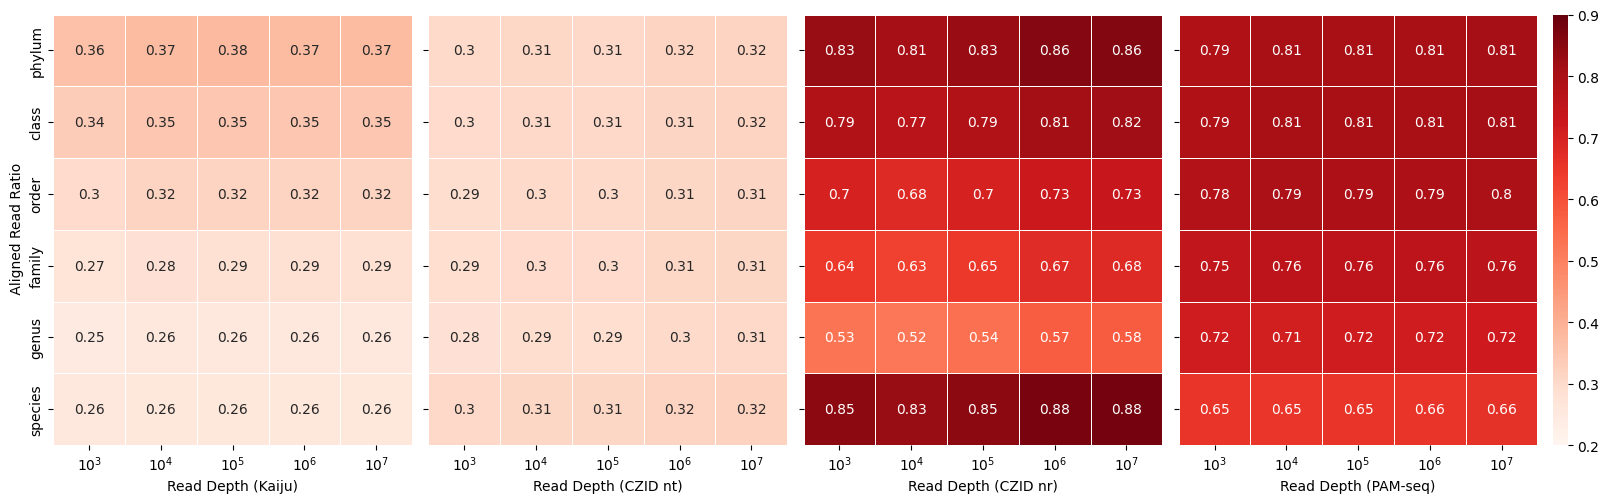

In [17]:
## plot the total aligned abundance
# Initialize a figure with 4 subplots in a row
headers= ['Kaiju', 'CZID nt', 'CZID nr', 'PAM-seq']

total_rel_abd_1=pd.read_csv(kaiju_dir+'all_persentage_reads_annotated_heatmap_kaiju.csv', index_col=0)
total_rel_abd_2=pd.read_csv(czi_dir+'all_persentage_reads_annotated_heatmap_nt.csv', index_col=0)
total_rel_abd_3=pd.read_csv(czi_dir+'all_persentage_reads_annotated_heatmap_nr.csv', index_col=0)
total_rel_abd_4=pd.read_csv(out_dir+'all_persentage_reads_annotated_heatmap.csv', index_col =0)
# Example setup
fig = plt.figure(figsize=(18, 5))  # Increase figure width for better spacing
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.04])  # Last column for color bar

# Create 4 subplots
axs = [fig.add_subplot(gs[i]) for i in range(4)]
data_list = [total_rel_abd_1, total_rel_abd_2, total_rel_abd_3, total_rel_abd_4]

# Define a single color bar axis
cbar_ax = fig.add_subplot(gs[4])

# Plot heatmaps
for i, (ax, data) in enumerate(zip(axs, data_list)):
    sns.heatmap(
        data,
        vmin=0.2,
        vmax=0.9,
        square=True,
        linewidths=0.5,
        annot=True,
        cmap='Reds',
        ax=ax,
        cbar=i == 0,  # Add color bar only to the first plot
        cbar_ax=None if i > 0 else cbar_ax  # Share color bar
    )
    ax.set_xlabel('Read Depth ({})'.format(headers[i]))
    ax.set_xticklabels(['$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$'], rotation=0)
    if i == 0:
        ax.set_ylabel(" Aligned Read Ratio")
    else:
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for color bar
plt.savefig(out_dir+'ocean_subsampling_meta_vs_pam_aligned_reads_ration_heatmap.pdf', format='pdf', bbox_inches='tight')
plt.savefig(out_dir+'ocean_subsampling_meta_vs_pam_aligned_reads_ration_heatmap.jpg',  bbox_inches='tight')

plt.show()

In [101]:
## count of taxa

In [19]:
cmb_taxon_cnt_all_level=pd.DataFrame()
for t in taxa[1:]:
    cmb_taxon_cnt=pd.read_csv(out_dir + 'ocean_pam_{}_level_taxa_count.csv'.format(t), index_col=0)
    cmb_taxon_cnt_all_level=pd.concat([cmb_taxon_cnt_all_level,cmb_taxon_cnt], axis=0)
cmb_taxon_cnt_all_level.to_csv(out_dir+ 'ocean_pam_seq_taxon_count_all_levels.csv')

In [20]:
total_rel_abd_all_taxa = pd.DataFrame()
for t in taxa[1:]:
    total_rel_abd = pd.read_csv(kaiju_dir + 'ocean_kaiju_{}_level_taxa_count.csv'.format(t.lower()), index_col = 0)
    total_rel_abd_all_taxa =  pd.concat([total_rel_abd_all_taxa, total_rel_abd], axis=0)
total_rel_abd_all_taxa.to_csv(kaiju_dir+'all_persentage_reads_annotated_heatmap_kaiju.csv')

In [21]:

total_rel_abd_all_taxa = pd.DataFrame()
for t in taxa[1:]:
    total_rel_abd = pd.read_csv(czi_dir + 'ocean_czi_{}_level_taxa_count_nr.csv'.format(t.lower()),index_col=0)
    total_rel_abd_all_taxa =  pd.concat([total_rel_abd_all_taxa, total_rel_abd], axis=0)
total_rel_abd_all_taxa.to_csv(czi_dir+'all_persentage_reads_annotated_heatmap_czid_nr.csv')

total_rel_abd_all_taxa = pd.DataFrame()
for t in taxa[1:]:
    total_rel_abd = pd.read_csv(czi_dir + 'ocean_czi_{}_level_taxa_count_nt.csv'.format(t.lower()),index_col=0)
    total_rel_abd_all_taxa =  pd.concat([total_rel_abd_all_taxa, total_rel_abd], axis=0)
total_rel_abd_all_taxa.to_csv(czi_dir+'all_persentage_reads_annotated_heatmap_czid_nt.csv')

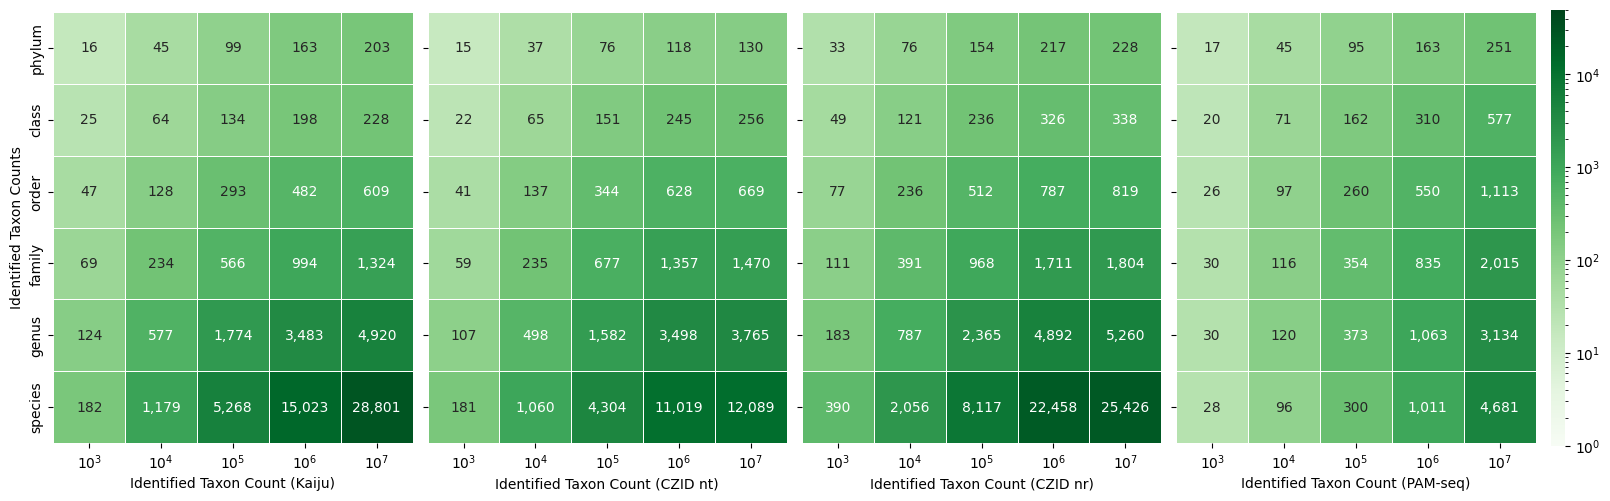

In [22]:
import matplotlib.colors as mcolors
## plot the total aligned abundance
# Initialize a figure with 4 subplots in a row
headers= ['Kaiju', 'CZID nt', 'CZID nr', 'PAM-seq']

total_rel_abd_1=pd.read_csv(kaiju_dir+'all_persentage_reads_annotated_heatmap_kaiju.csv', index_col=0)
total_rel_abd_2=pd.read_csv(czi_dir+'all_persentage_reads_annotated_heatmap_czid_nt.csv', index_col=0)
total_rel_abd_3=pd.read_csv(czi_dir+'all_persentage_reads_annotated_heatmap_czid_nr.csv', index_col=0)
total_rel_abd_4=pd.read_csv(out_dir+ 'ocean_pam_seq_taxon_count_all_levels.csv', index_col =0)
# Example setup
fig = plt.figure(figsize=(18, 5))  # Increase figure width for better spacing
gs = gridspec.GridSpec(1, 5, width_ratios=[1, 1, 1, 1, 0.04])  # Last column for color bar

# Create 4 subplots
axs = [fig.add_subplot(gs[i]) for i in range(4)]
data_list = [total_rel_abd_1, total_rel_abd_2, total_rel_abd_3, total_rel_abd_4]

# Define a single color bar axis
cbar_ax = fig.add_subplot(gs[4])

# Plot heatmaps
for i, (ax, data) in enumerate(zip(axs, data_list)):
    sns.heatmap(
        data,
        norm=mcolors.LogNorm(vmax = 50000, vmin =1),
        square=True,
        linewidths=0.5,
        annot=True,
        fmt=",.0f", 
        cmap='Greens',
        ax=ax,
        cbar=i == 0,  # Add color bar only to the first plot
        cbar_ax=None if i > 0 else cbar_ax  # Share color bar
    )
    ax.set_xlabel('Identified Taxon Count ({})'.format(headers[i]))
    ax.set_xticklabels(['$10^3$', '$10^4$', '$10^5$', '$10^6$', '$10^7$'], rotation=0)
    if i == 0:
        ax.set_ylabel("Identified Taxon Counts")
    else:
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for color bar
plt.savefig(out_dir+'ocean_subsampling_meta_vs_pam_identified_taxon_counts_heatmap.pdf', format='pdf', bbox_inches='tight')
plt.savefig(out_dir+'ocean_subsampling_meta_vs_pam_identified_taxon_counts_heatmap.jpg',  bbox_inches='tight')

plt.show()

In [25]:
data_list

[            1K     10K    100K       1M       10M
 phylum    16.4    45.0    98.6    162.8    203.00
 class     25.0    64.0   134.0    197.8    228.50
 order     46.6   128.0   293.0    482.0    609.25
 family    68.8   234.4   565.6    994.2   1323.50
 genus    123.8   577.0  1774.4   3483.0   4919.75
 species  182.0  1178.8  5268.0  15023.0  28801.00,
           1000   10000  100000  1000000  10000000
 phylum    15.2    37.4    75.6    118.2     130.0
 class     22.4    64.6   151.4    244.8     255.8
 order     40.8   137.2   343.8    628.2     669.0
 family    58.8   235.2   676.8   1357.2    1470.2
 genus    107.0   498.0  1581.6   3497.8    3765.0
 species  181.4  1059.8  4304.2  11019.4   12089.0,
           1000   10000  100000  1000000  10000000
 phylum    33.0    76.0   154.2    217.0     228.4
 class     49.4   121.0   236.4    326.0     338.2
 order     77.2   236.2   511.8    787.0     819.2
 family   111.0   390.6   968.0   1711.4    1803.8
 genus    183.2   786.8  2365

In [23]:
# plot shannon and PCA

ANOVA result for Shannon Alpha Diversity: F_onewayResult(statistic=np.float64(1266.4755928607224), pvalue=np.float64(1.926454578721102e-76))
Spearman Correlation between Read Depth and Shannon Alpha Diversity: SignificanceResult(statistic=np.float64(0.20275556835602324), pvalue=np.float64(0.04414322908887413))
Mantel test result for Read Depth vs Bray-Curtis: (np.float64(-0.02305806614135933), np.float64(0.189), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.01837870345784532 and the largest is 14.171883642992341.
  warn(


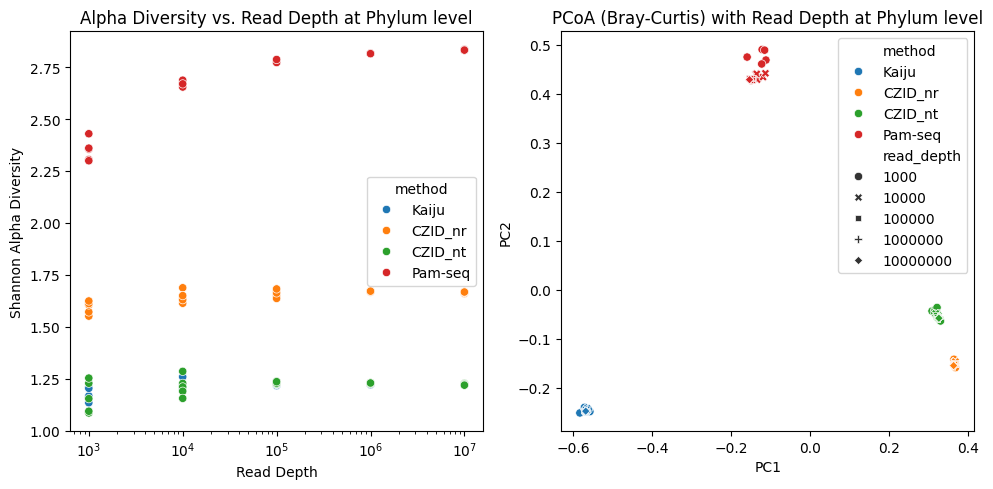

ANOVA result for Shannon Alpha Diversity: F_onewayResult(statistic=np.float64(223.06499984844106), pvalue=np.float64(7.172775859060728e-43))
Spearman Correlation between Read Depth and Shannon Alpha Diversity: SignificanceResult(statistic=np.float64(0.30485919272706624), pvalue=np.float64(0.002153720291626451))
Mantel test result for Read Depth vs Bray-Curtis: (np.float64(-0.01686598391860812), np.float64(0.66), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.018749861561325545 and the largest is 6.929455961855646.
  warn(


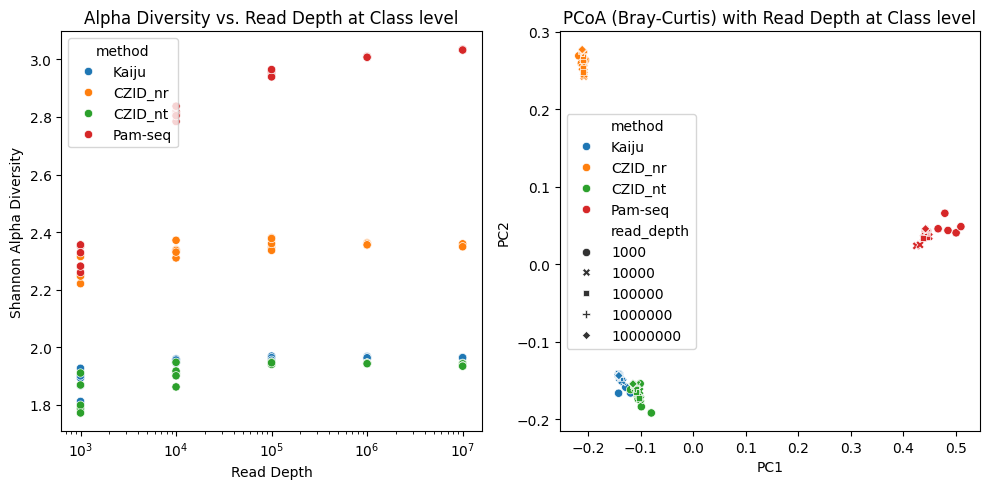

ANOVA result for Shannon Alpha Diversity: F_onewayResult(statistic=np.float64(48.10601659914343), pvalue=np.float64(5.343607524622288e-19))
Spearman Correlation between Read Depth and Shannon Alpha Diversity: SignificanceResult(statistic=np.float64(0.43350963320150343), pvalue=np.float64(7.386540684994855e-06))
Mantel test result for Read Depth vs Bray-Curtis: (np.float64(-0.024258988720593653), np.float64(0.503), 99)


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.024401484830195393 and the largest is 7.745771120446724.
  warn(


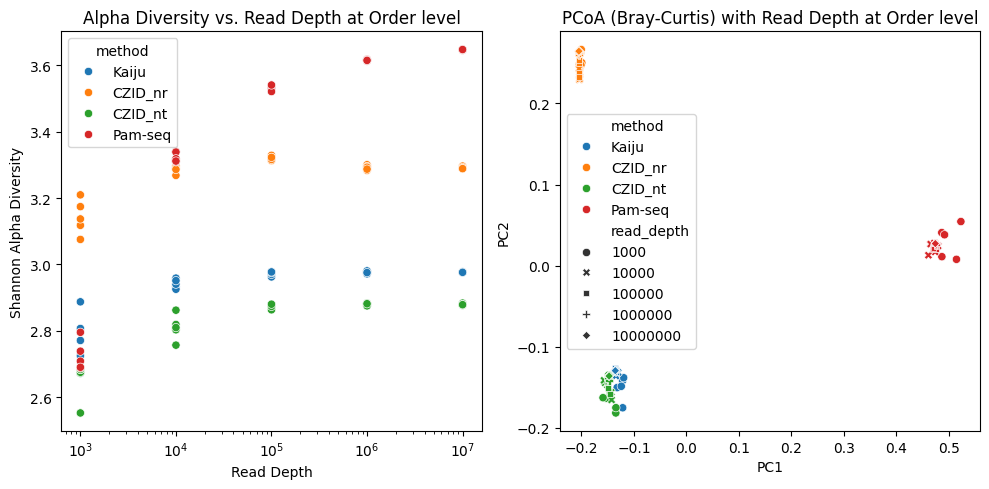

ANOVA result for Shannon Alpha Diversity: F_onewayResult(statistic=np.float64(16.776747183980035), pvalue=np.float64(7.98223450691287e-09))
Spearman Correlation between Read Depth and Shannon Alpha Diversity: SignificanceResult(statistic=np.float64(0.5790500593850902), pvalue=np.float64(3.4181395853208357e-10))


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03908915256529892 and the largest is 9.230426705331865.
  warn(


Mantel test result for Read Depth vs Bray-Curtis: (np.float64(-0.035677578048610964), np.float64(0.283), 99)


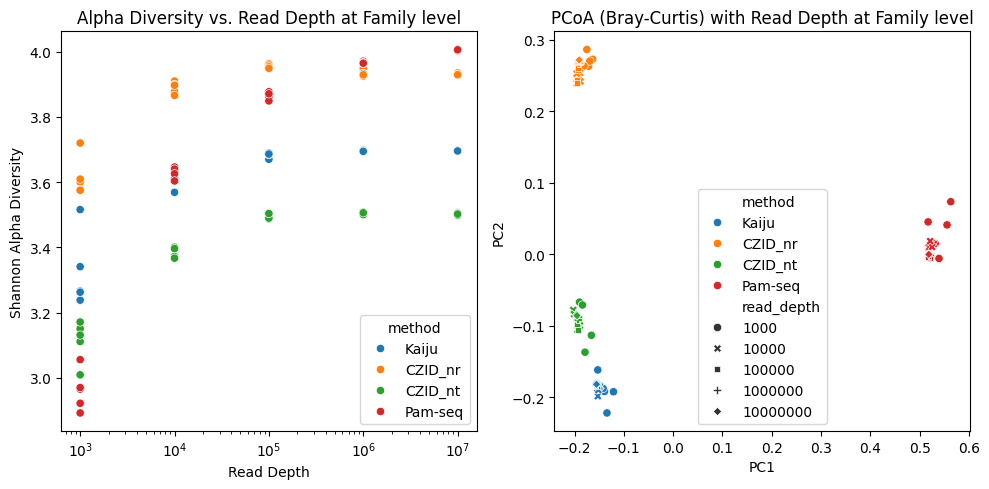

ANOVA result for Shannon Alpha Diversity: F_onewayResult(statistic=np.float64(79.7124671561865), pvalue=np.float64(7.564239315060379e-26))
Spearman Correlation between Read Depth and Shannon Alpha Diversity: SignificanceResult(statistic=np.float64(0.46528881034857655), pvalue=np.float64(1.2193148584852824e-06))


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.015864607502944612 and the largest is 11.584900146223637.
  warn(


Mantel test result for Read Depth vs Bray-Curtis: (np.float64(-0.05720759203546154), np.float64(0.085), 99)


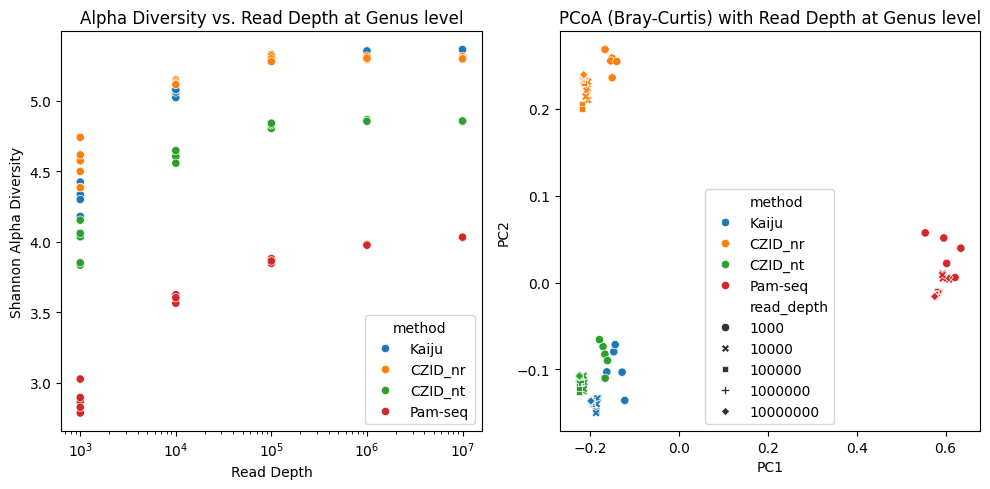

ANOVA result for Shannon Alpha Diversity: F_onewayResult(statistic=np.float64(162.6202958175961), pvalue=np.float64(2.7163099324566562e-37))
Spearman Correlation between Read Depth and Shannon Alpha Diversity: SignificanceResult(statistic=np.float64(0.5213299849044578), pvalue=np.float64(3.153937867353662e-08))


/home/xiangpeng/miniconda3/envs/myenv/lib/python3.9/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:146: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0029084855849922124 and the largest is 14.233630011776118.
  warn(


Mantel test result for Read Depth vs Bray-Curtis: (np.float64(-0.055141028751248065), np.float64(0.012), 99)


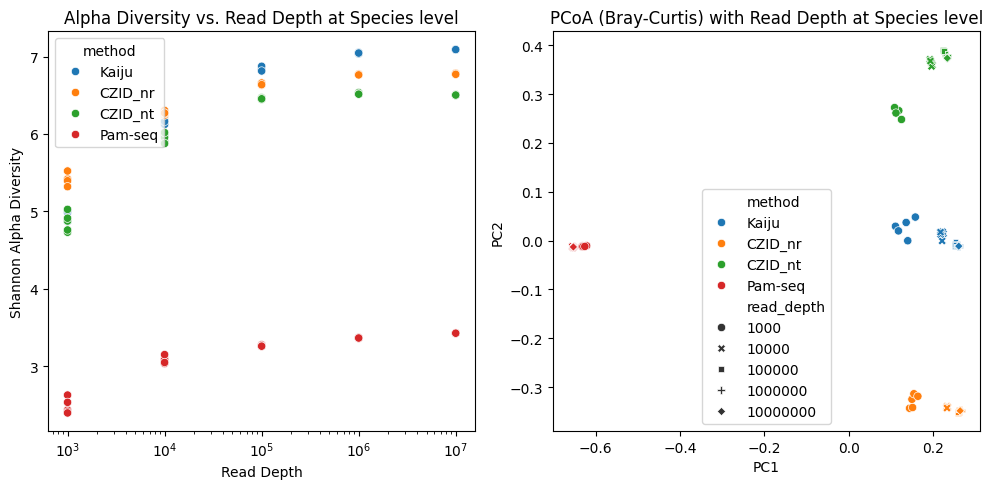

In [128]:

# Set up subplots: 1 row, 2 columns
 # Two subplots in a row

metadata = pd.read_csv(out_dir+ 'all_method_combined_df_metadata.csv', index_col=0)
for t in taxa[1:]:
    fig, axs = plt.subplots(1, 2, figsize=(10,5)) 
    # Load data for the current taxon
    rel_abd_all_methods = pd.read_csv(out_dir+ 'ocean_sub_sample_all_method_combined_at_{}_taxa_level.csv'.format(t), index_col=0)
    df_taxa = rel_abd_all_methods.T
    df_meta = metadata
    df_taxa.index.name = 'Sample'
    df_meta.index.name = 'Sample'
    
    # Alpha Diversity (shannon, simpson, etc.)
    alpha_metrics = ['shannon', 'simpson', 'observed_otus']
    alpha_results = {metric: alpha_diversity(metric, df_taxa.values, df_taxa.index) for metric in alpha_metrics}
    df_alpha = pd.DataFrame(alpha_results, index=df_taxa.index)
    
    # Bray-Curtis distance matrix for Beta diversity
    dist_matrix = beta_diversity('braycurtis', df_taxa.values, df_taxa.index)
    
    # ANOSIM Test
    grouping = df_meta['method']
    anosim_result = anosim(dist_matrix, grouping)
    
    # Merge alpha diversity and metadata
    df_alpha_meta = df_alpha.merge(df_meta, left_index=True, right_index=True)
    
    # Scatter plot for Alpha Diversity vs. Read Depth
    sns.scatterplot(data=df_alpha_meta, x='read_depth', y='shannon', hue='method', ax=axs[0])
    axs[0].set_title('Alpha Diversity vs. Read Depth at {} level'.format(t))
    axs[0].set_xscale('log')
    axs[0].set_xlabel('Read Depth')
    axs[0].set_ylabel('Shannon Alpha Diversity')

    # Perform ANOVA for method (for alpha diversity)
    groups = [group['shannon'].values for _, group in df_alpha_meta.groupby('method')]
    anova_result = f_oneway(*groups)
    print('ANOVA result for Shannon Alpha Diversity:', anova_result)

    # Spearman Correlation with Read Depth
    corr_result = spearmanr(df_alpha_meta['read_depth'], df_alpha_meta['shannon'])
    print('Spearman Correlation between Read Depth and Shannon Alpha Diversity:', corr_result)
    
    # Perform PCoA (Principal Coordinate Analysis) on Bray-Curtis distance matrix
    pcoa_results = pcoa(dist_matrix)
    df_pcoa = pcoa_results.samples
    df_pcoa_meta = df_pcoa.merge(df_meta, left_index=True, right_index=True)
    
    # Scatter plot for PCoA with Read Depth
    sns.scatterplot(data=df_pcoa_meta, x='PC1', y='PC2', style='read_depth', hue='method', ax=axs[1])
    axs[1].set_title('PCoA (Bray-Curtis) with Read Depth at {} level'.format(t))
    axs[1].set_xlabel('PC1')
    axs[1].set_ylabel('PC2')
    
    # Mantel test for read depth vs. Bray-Curtis distance
    read_depth_matrix = np.abs(df_meta['read_depth'].values[:, None] - df_meta['read_depth'].values)
    read_depth_dist_matrix = DistanceMatrix(read_depth_matrix, ids=df_meta.index)
    mantel_result = mantel(dist_matrix, read_depth_dist_matrix)
    print('Mantel test result for Read Depth vs Bray-Curtis:', mantel_result)
    # Adjust layout
    plt.tight_layout()
    plt.savefig(out_dir+'ocean_subsampling_meta_vs_pam_alpha_diversity_PCA_{}_leve.pdf'.format(t), format='pdf', bbox_inches='tight')
    plt.savefig(out_dir+'ocean_subsampling_meta_vs_pam_alpha_diversity_PCA_{}_leve.jpg'.format(t),  bbox_inches='tight')
    plt.show()




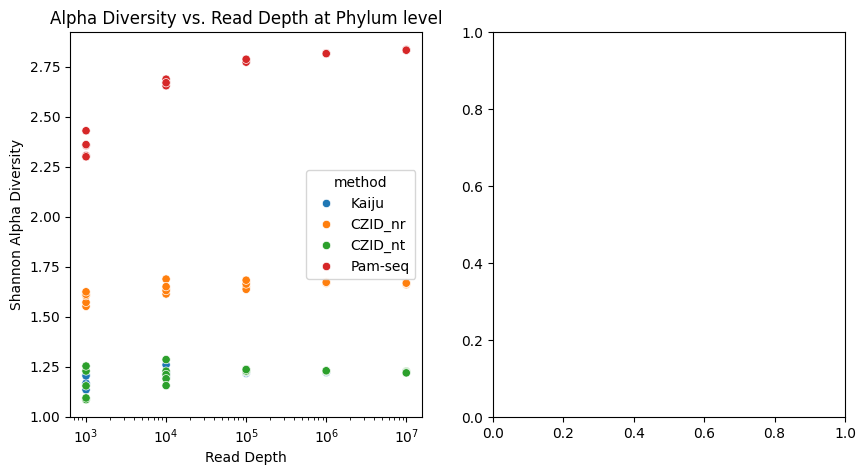

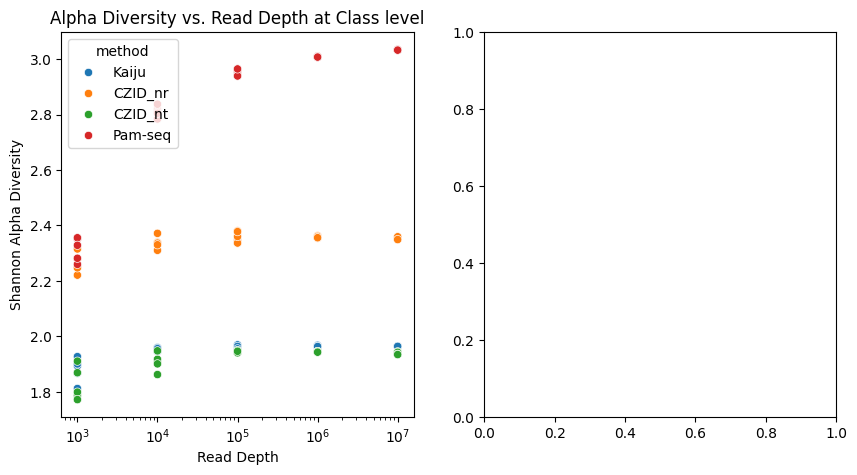

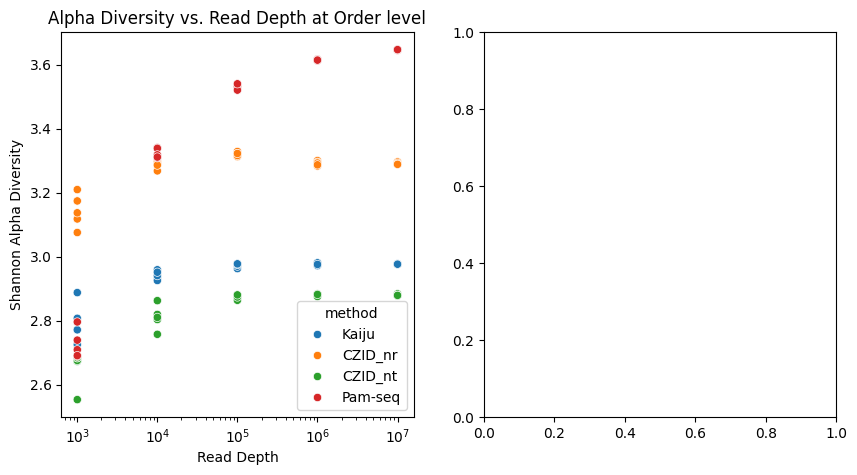

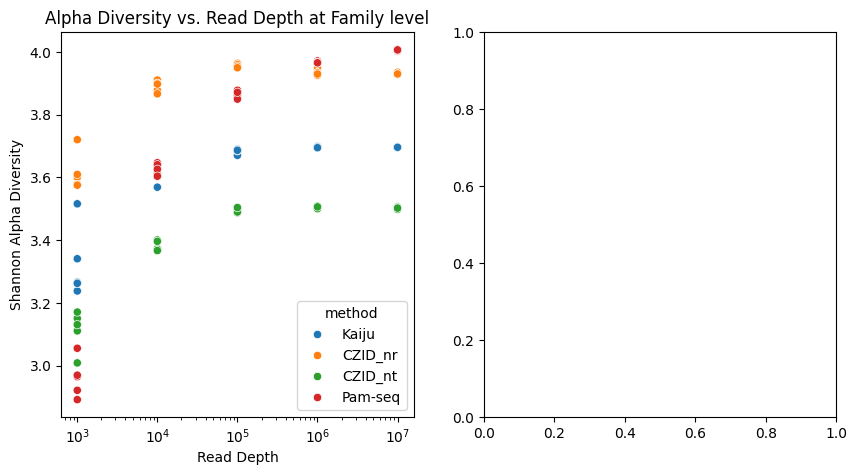

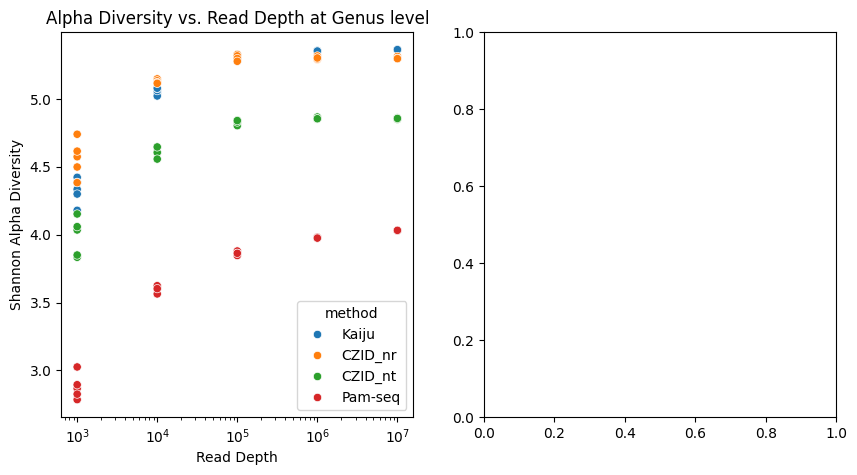

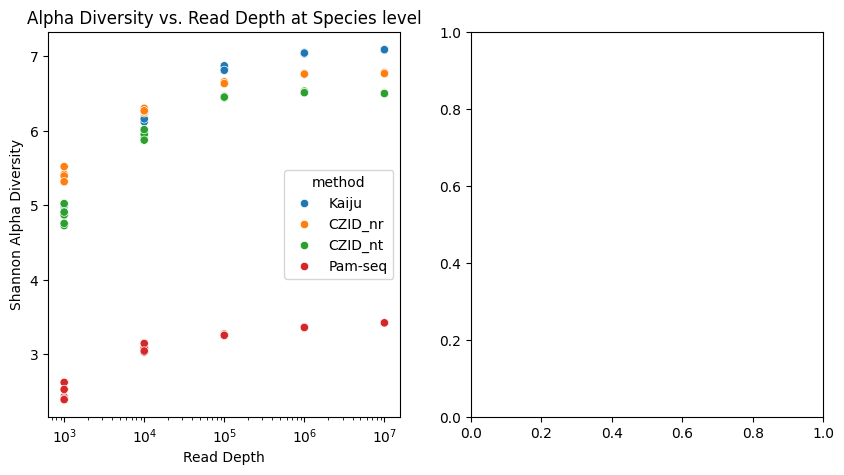

In [33]:

# Set up subplots: 1 row, 2 columns
 # Two subplots in a row
df_alpha_meta_all=pd.DataFrame()
metadata = pd.read_csv(out_dir+ 'all_method_combined_df_metadata.csv', index_col=0)
for t in taxa[1:]:
    fig, axs = plt.subplots(1, 2, figsize=(10,5)) 
    # Load data for the current taxon
    rel_abd_all_methods = pd.read_csv(out_dir+ 'ocean_sub_sample_all_method_combined_at_{}_taxa_level.csv'.format(t), index_col=0)
    df_taxa = rel_abd_all_methods.T
    df_meta = metadata
    df_taxa.index.name = 'Sample'
    df_meta.index.name = 'Sample'
    
    # Alpha Diversity (shannon, simpson, etc.)
    alpha_metrics = ['shannon', 'simpson', 'observed_otus']
    alpha_results = {metric: alpha_diversity(metric, df_taxa.values, df_taxa.index) for metric in alpha_metrics}
    df_alpha = pd.DataFrame(alpha_results, index=df_taxa.index)
    
    # Bray-Curtis distance matrix for Beta diversity
    dist_matrix = beta_diversity('braycurtis', df_taxa.values, df_taxa.index)
    
    # ANOSIM Test
    grouping = df_meta['method']
    anosim_result = anosim(dist_matrix, grouping)
    
    # Merge alpha diversity and metadata
    df_alpha_meta = df_alpha.merge(df_meta, left_index=True, right_index=True)
    
    # Scatter plot for Alpha Diversity vs. Read Depth
    sns.scatterplot(data=df_alpha_meta, x='read_depth', y='shannon', hue='method', ax=axs[0])
    axs[0].set_title('Alpha Diversity vs. Read Depth at {} level'.format(t))
    axs[0].set_xscale('log')
    axs[0].set_xlabel('Read Depth')
    axs[0].set_ylabel('Shannon Alpha Diversity')
    df_alpha_meta['taxon_level']=t
    df_alpha_meta_all = pd.concat([df_alpha_meta_all, df_alpha_meta], axis=0)

  
 



In [35]:
df_alpha_meta_all.to_csv(wk_dir+'ocean_subsample_all_methods_alpha_diversity.csv')